In [1]:
import pandas as pd
import requests
import os
import prepare as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


## Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

## For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

### store df

In [2]:
store_df = p.wrangle_tsa()

In [3]:
store_df.head()

item_upc14   item_upc12          item_brand  \
sale_date                                                  
2013-01-01  35200264013  35200264013            Riceland   
2013-01-01  88313590791  88313590791               Ducal   
2013-01-01  70177154004  70177154004  Twinings Of London   
2013-01-01  21200725340  21200725340              Scotch   
2013-01-01  41520035646  41520035646             Careone   

                                                    item_name  item_price  \
sale_date                                                                   
2013-01-01                     Riceland American Jazmine Rice        0.84   
2013-01-01                            Ducal Refried Red Beans        1.16   
2013-01-01  Twinings Of London Classics Lady Grey Tea - 20 Ct        9.64   
2013-01-01    Scotch Removable Clear Mounting Squares - 35 Ct        4.39   
2013-01-01                     Careone Family Comb Set - 8 Ct        0.74   

            sale_id  store_id  item_id.1  sale_amount  store_id.1  \
sale_date                                                           
2013-01-01        1         1          1           13           1   
2013-01-01   295813         3         17           26           3   
2013-01-01   125995        10          7           32          10   
2013-01-01   314073         3         18           45           3   
2013-01-01   332333         3         19           34           3   

                      store_address  store_zipcode   store_city store_state  \
sale_date                                                                     
2013-01-01   12125 Alamo Ranch Pkwy          78253  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   
2013-01-01     8503 NW Military Hwy          78231  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   

            month  day_of_week  sales_total  
sale_date                                    
2013-01-01      1            1        10.92  
2013-01-01      1            1        30.16  
2013-01-01      1            1       308.48  
2013-01-01      1            1       197.55  
2013-01-01      1            1        25.16

In [4]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)


In [5]:
print('Date Range:', store_df.index.min(), 'to', store_df.index.max())
print('Shape:', store_df.shape)

Date Range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Shape: (913000, 17)


In [6]:
train_size = .70
n = store_df.shape[0]
test_start_index = round(train_size * n)

train = store_df[:test_start_index]
test = store_df[test_start_index:] 

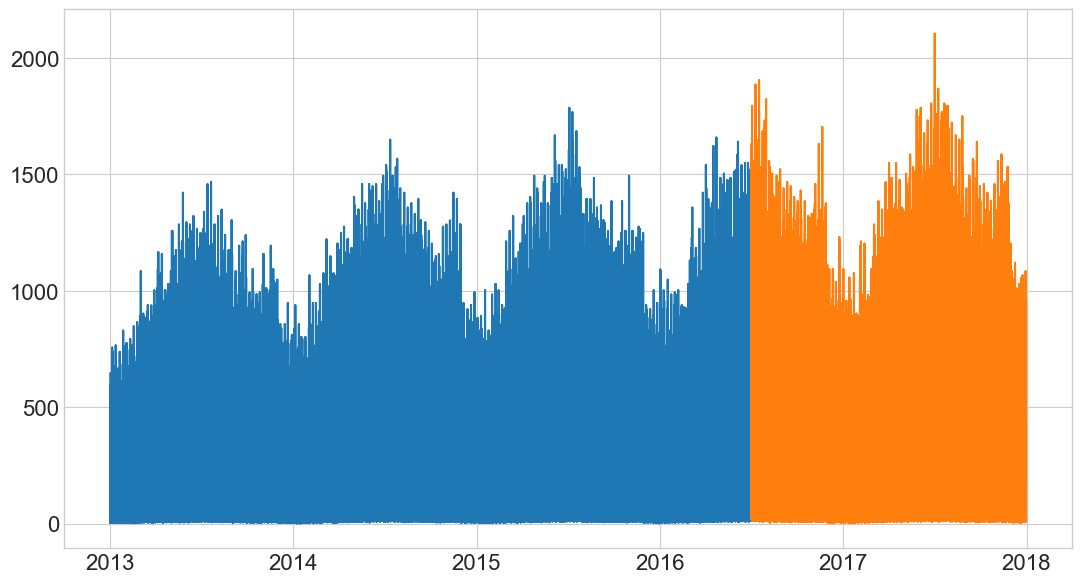

In [7]:
plt.plot(train.index, train.sales_total)
plt.plot(test.index, test.sales_total)

In [8]:
y = train.sales_total
y.head()


sale_date
2013-01-01     10.92
2013-01-01     30.16
2013-01-01    308.48
2013-01-01    197.55
2013-01-01     25.16
Name: sales_total, dtype: float64

<Axes: ylabel='Frequency'>

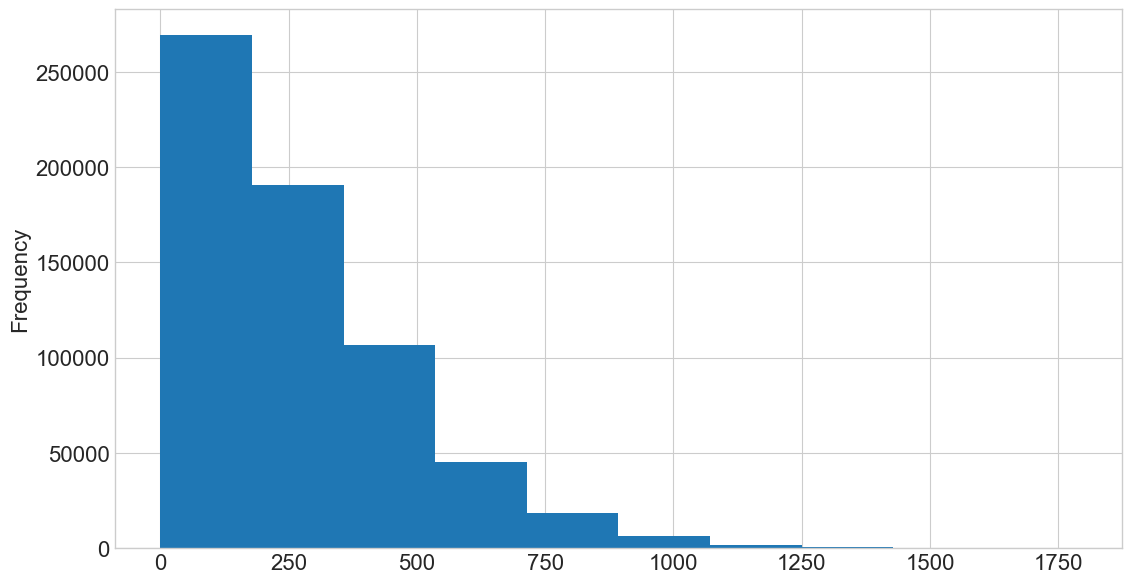

In [9]:
y.plot.hist()


[Text(0.5, 1.0, 'Average sales total by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'sales_total ($)')]

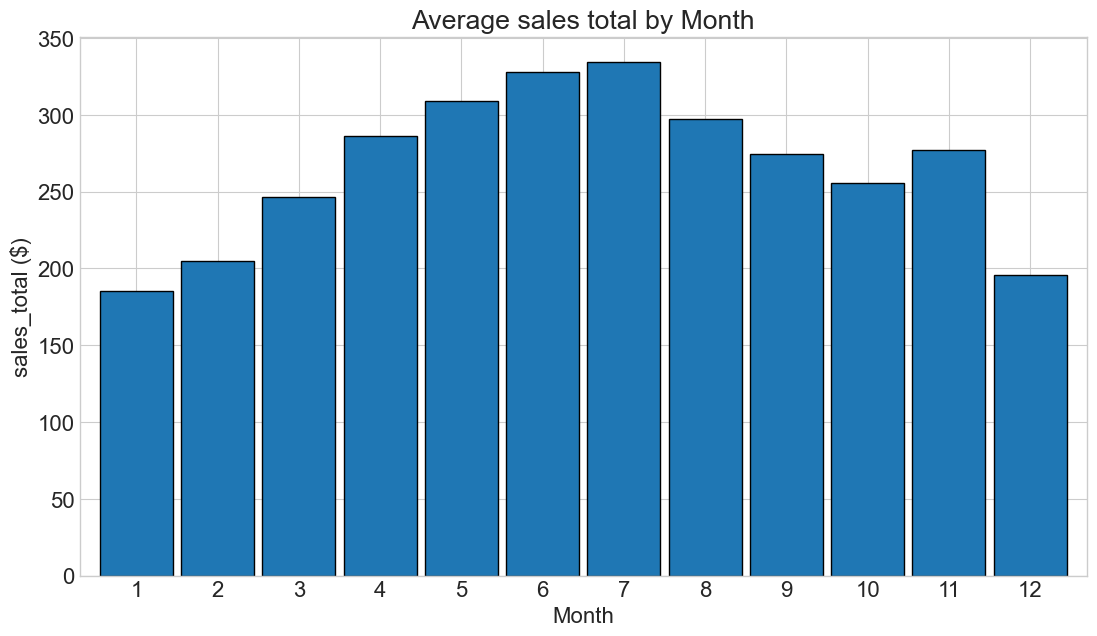

In [10]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average sales total by Month', xlabel='Month', ylabel='sales_total ($)')


[Text(0.5, 1.0, 'Average Sales total by Weekday'),
 Text(0.5, 30.0, 'Weekday'),
 Text(32.0, 0.5, 'Sales Total ($)')]

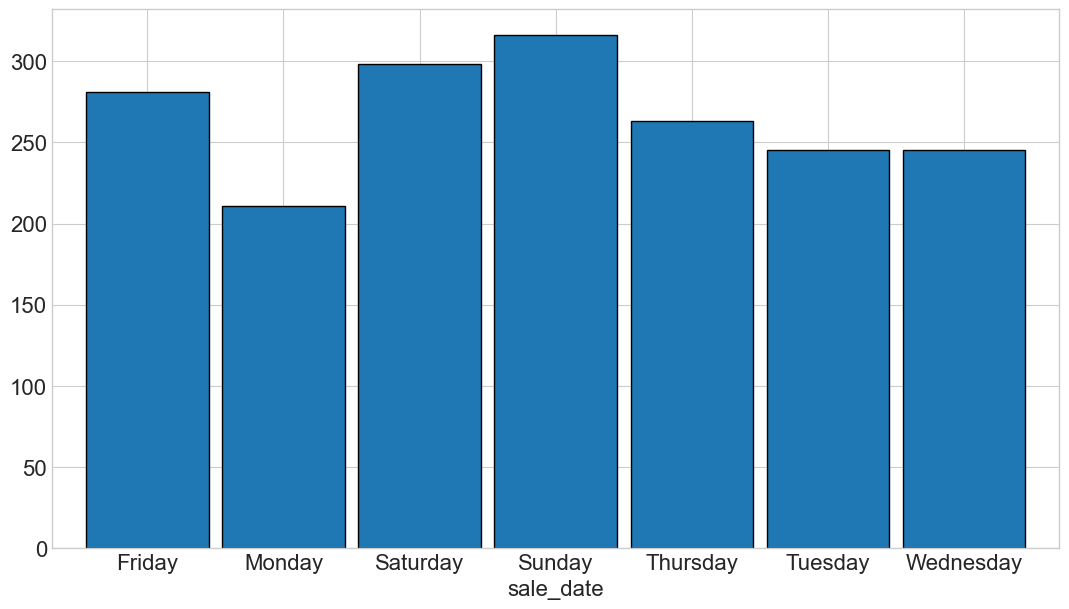

In [11]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales total by Weekday', xlabel='Weekday', ylabel='Sales Total ($)')


<Axes: xlabel='weekday', ylabel='sales_total'>

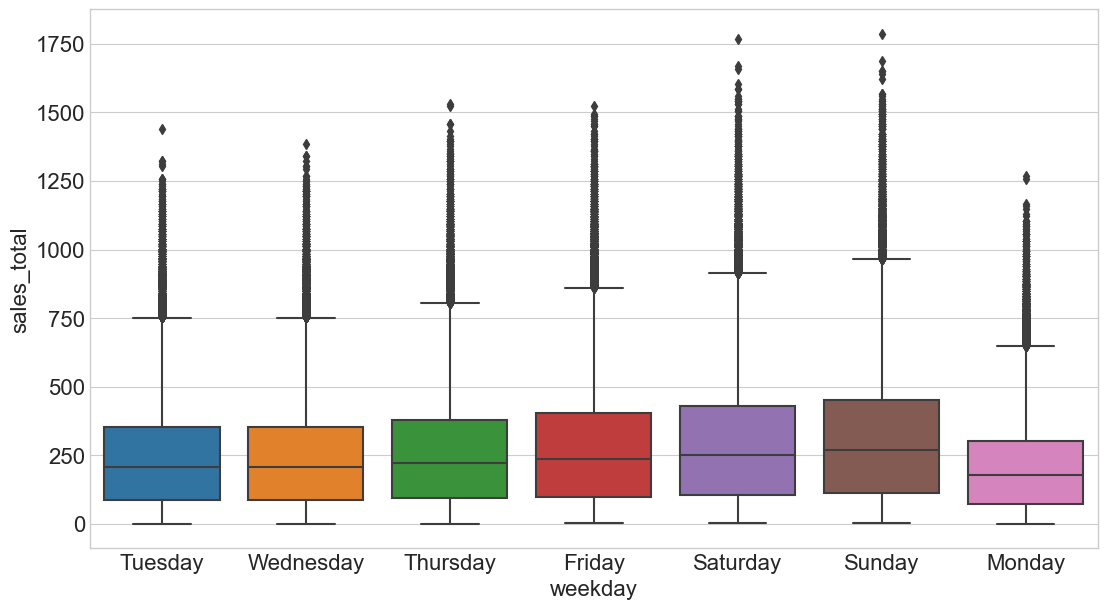

In [12]:
(
    y.reset_index()
    .assign(weekday=lambda store_df: store_df.sale_date.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='sales_total', x='weekday')
)


<Axes: xlabel='sale_date'>

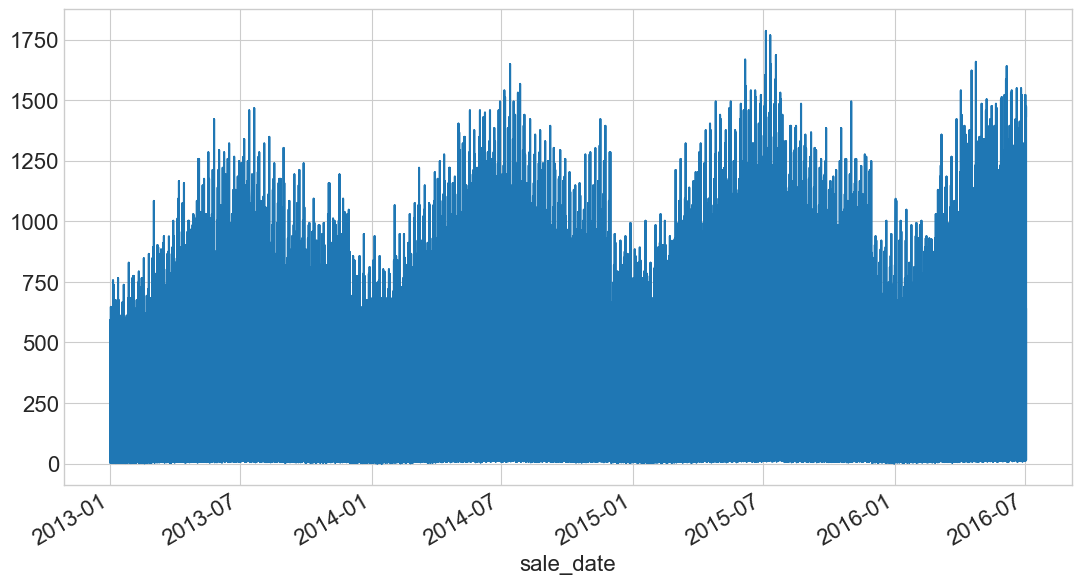

In [13]:
y.plot()


<Axes: title={'center': 'day average'}, xlabel='sale_date'>

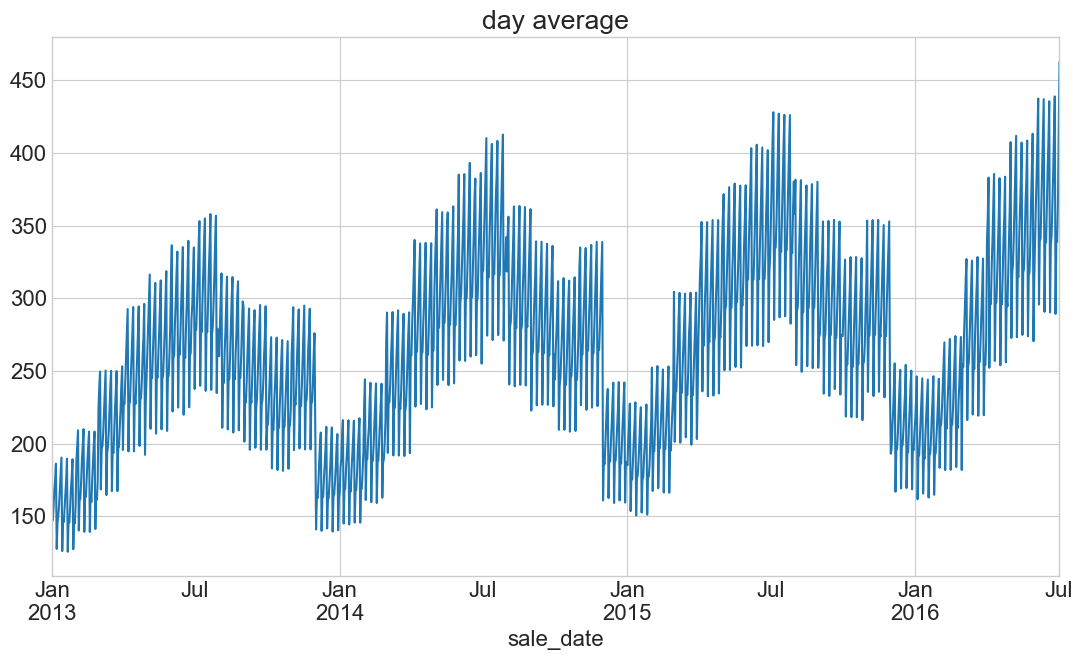

In [14]:
y.resample('D').mean().plot(title='day average')


## 2 week avg sales total

<Axes: title={'center': '2 week average sales total'}, xlabel='sale_date'>

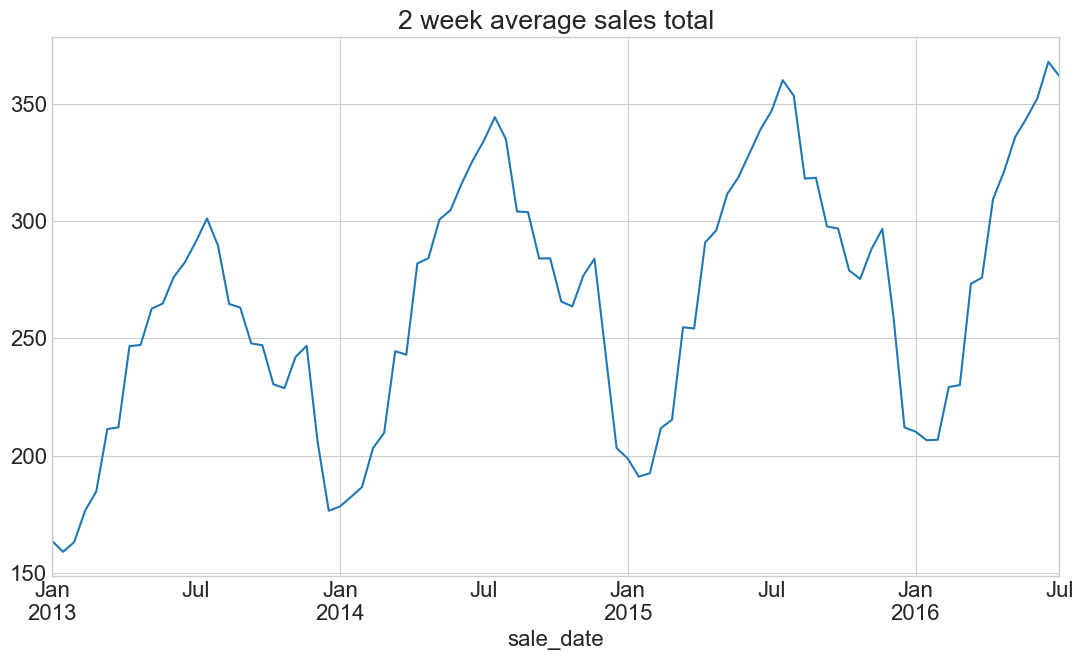

In [15]:
y.resample('2W').mean().plot(title='2 week average sales total')


## Visualizations to see how the aggregating smoothes out the data.

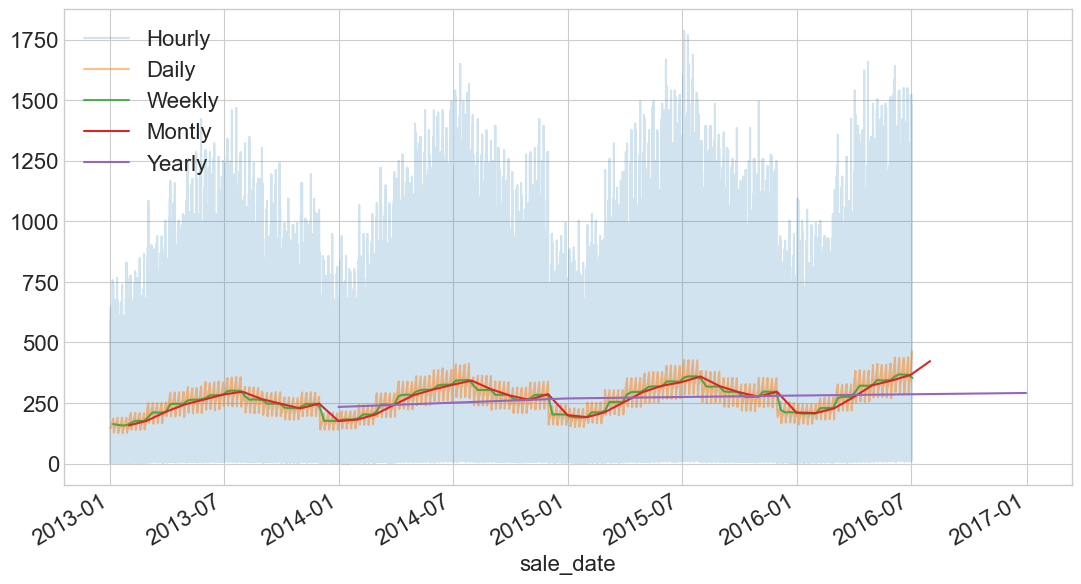

In [16]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


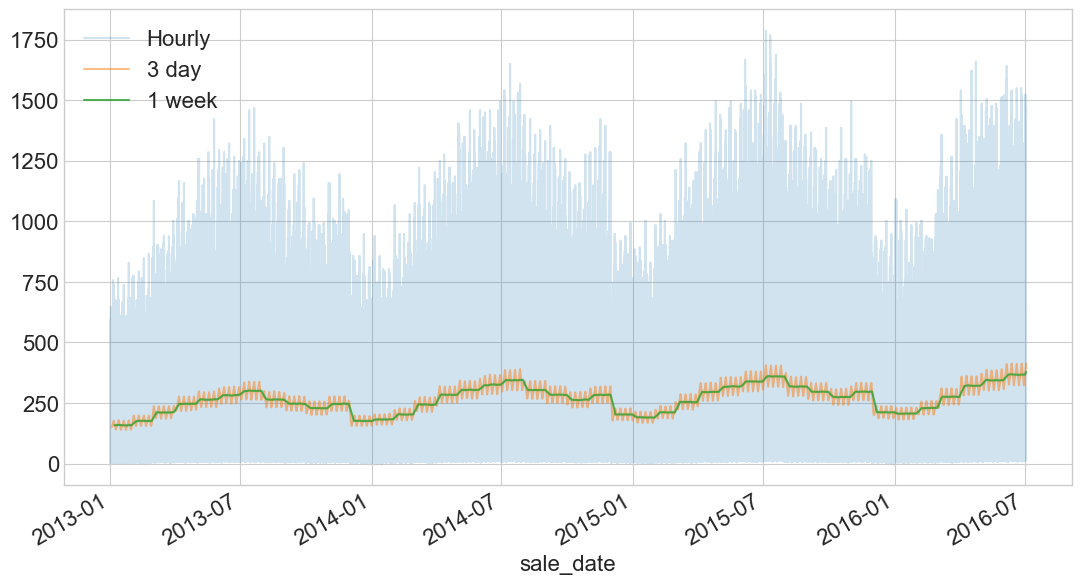

In [17]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

## Avg Week to Week sales total

<Axes: title={'center': 'Average week-to-week change in sales total'}, xlabel='sale_date'>

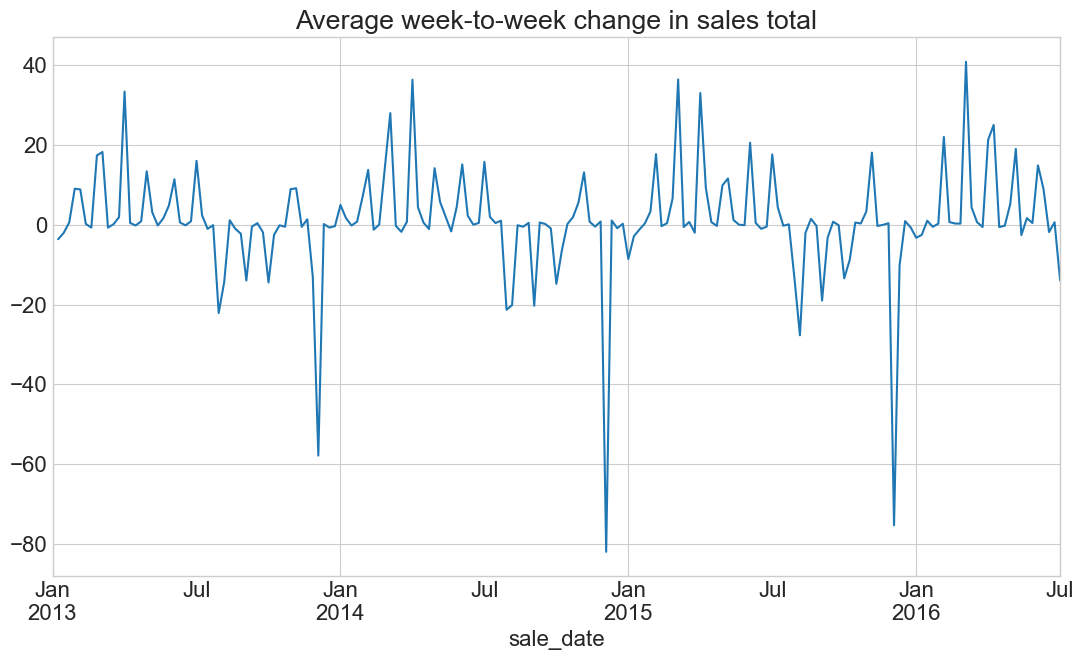

In [18]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in sales total')


## Average M to M plot

<Axes: title={'center': 'Average month-to-month change in sales total'}, xlabel='sale_date'>

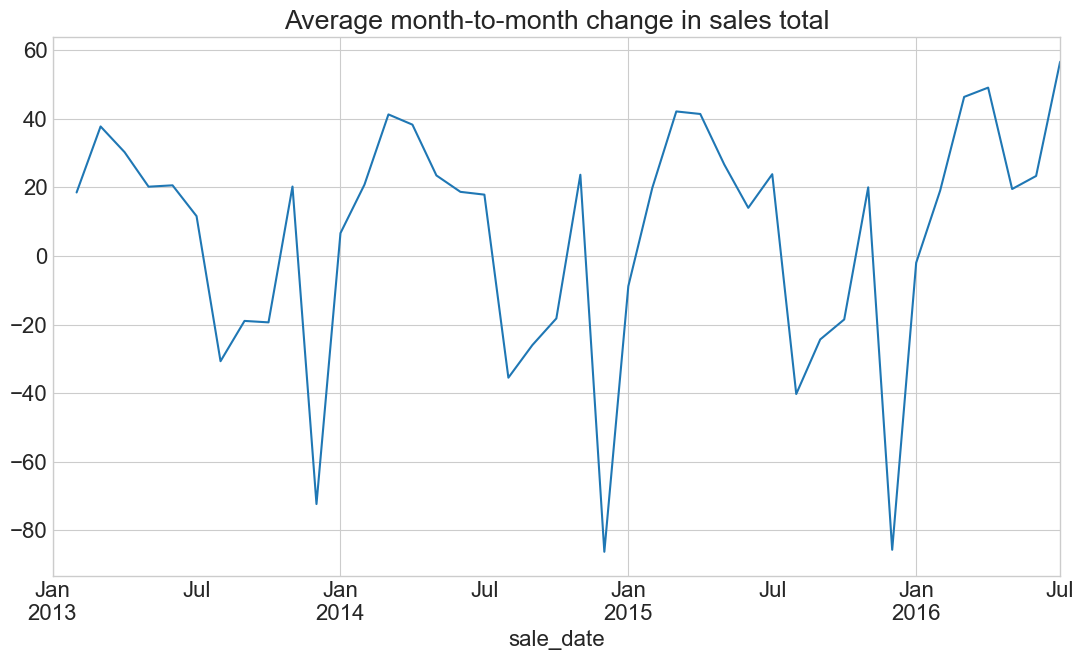

In [19]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in sales total')


## Seasonal plot

<Axes: title={'center': 'Seasonal Plot'}, xlabel='sale_date'>

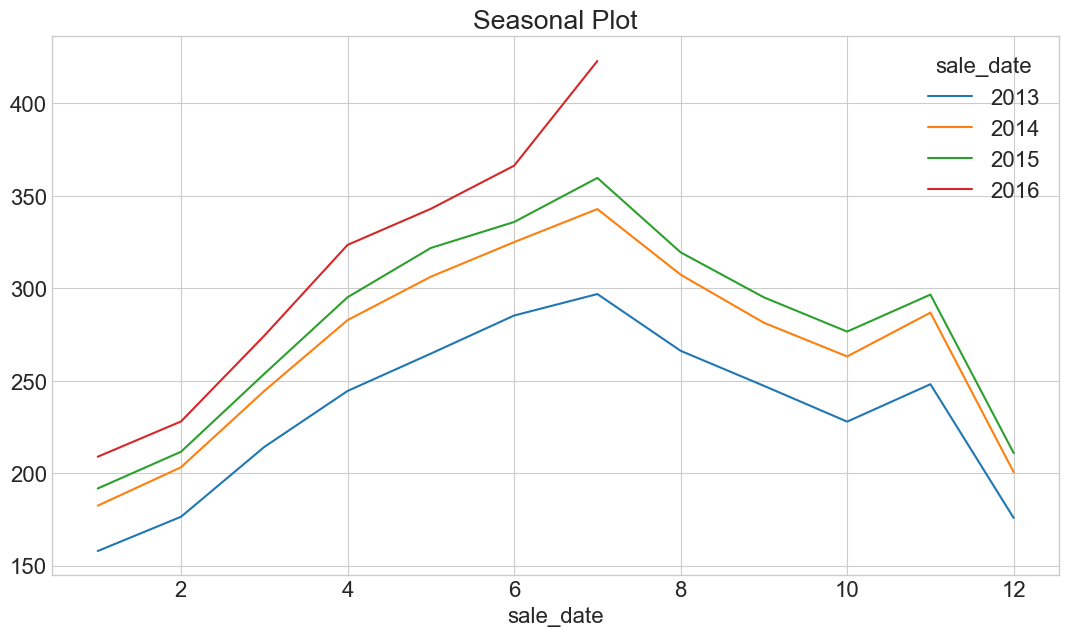

In [20]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


## Seasonal subseries Plot

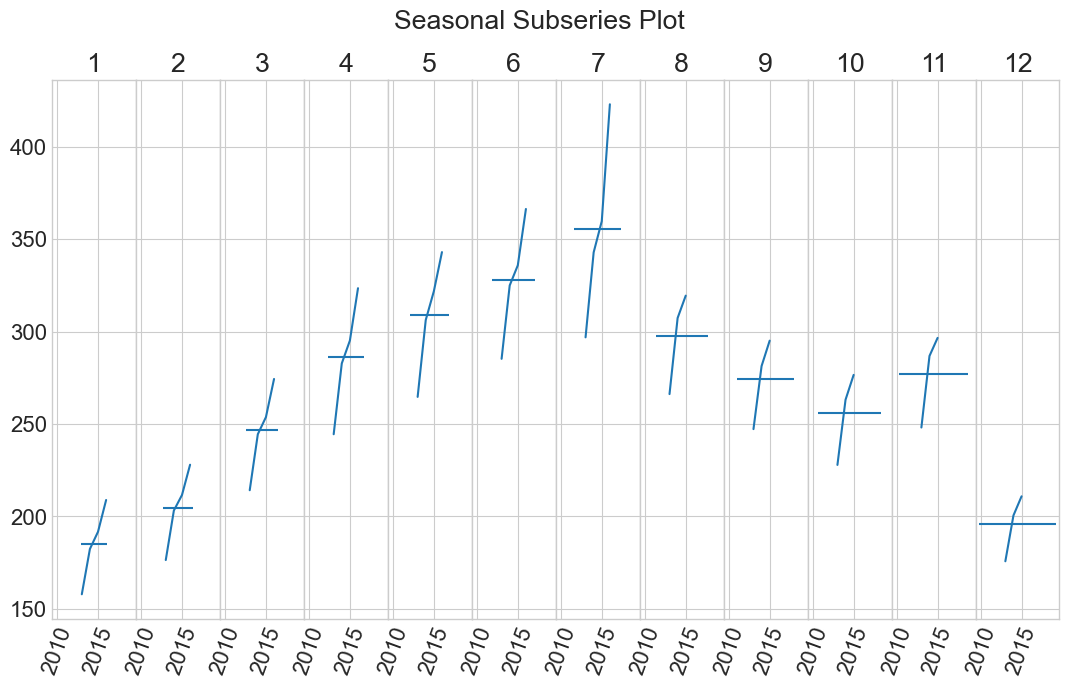

In [21]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iterrows()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    ax.set_xticklabels([int(thing) for thing in ax.get_xticks()], rotation = 70)

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


## Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

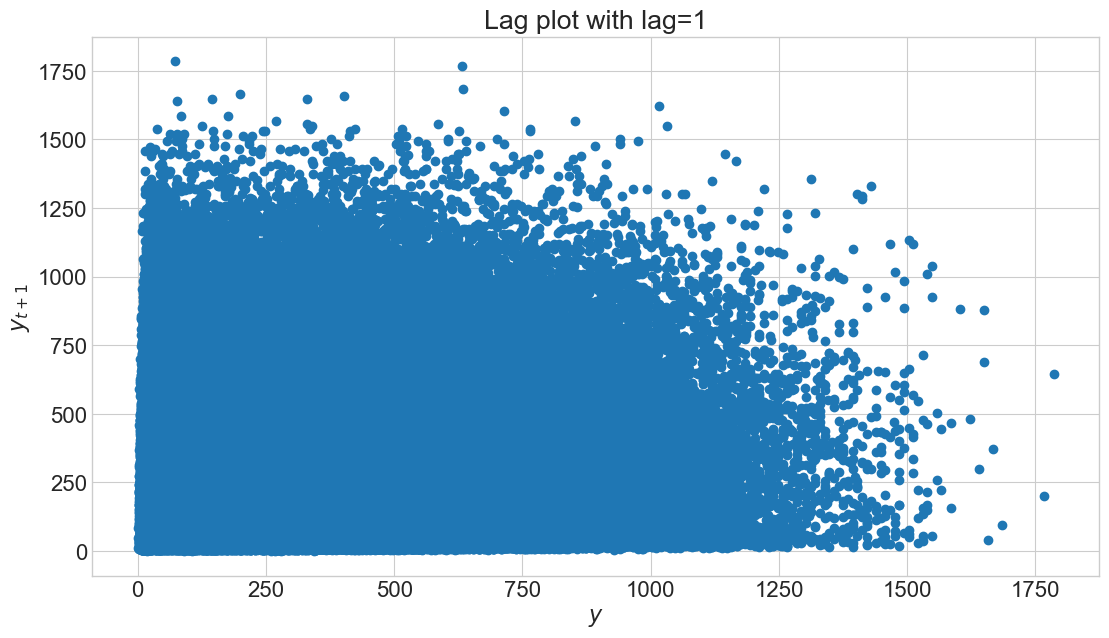

In [22]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


item_upc14    item_upc12  item_price        sale_id  store_id  \
sale_date                                                                     
2013-01-06  2.384688e+11  2.384688e+11    5.160400  455590.500000  5.500000   
2013-01-13  2.384688e+11  2.384688e+11    5.160400  455597.000000  5.500000   
2013-01-20  2.384688e+11  2.384688e+11    5.160400  455604.000000  5.500000   
2013-01-27  2.384688e+11  2.384688e+11    5.160400  455611.000000  5.500000   
2013-02-03  2.384688e+11  2.384688e+11    5.160400  455618.000000  5.500000   
...                  ...           ...         ...            ...       ...   
2016-06-05  2.384688e+11  2.384688e+11    5.160400  456836.000000  5.500000   
2016-06-12  2.384688e+11  2.384688e+11    5.160400  456843.000000  5.500000   
2016-06-19  2.384688e+11  2.384688e+11    5.160400  456850.000000  5.500000   
2016-06-26  2.384688e+11  2.384688e+11    5.160400  456857.000000  5.500000   
2016-07-03  2.397828e+11  2.397828e+11    5.151062  456361.667692  5.498462   

            item_id.1  sale_amount  store_id.1  store_zipcode     month  \
sale_date                                                                 
2013-01-06  25.500000    30.355667    5.500000   78224.800000  1.000000   
2013-01-13  25.500000    29.686286    5.500000   78224.800000  1.000000   
2013-01-20  25.500000    29.414286    5.500000   78224.800000  1.000000   
2013-01-27  25.500000    29.513714    5.500000   78224.800000  1.000000   
2013-02-03  25.500000    31.150571    5.500000   78224.800000  1.428571   
...               ...          ...         ...            ...       ...   
2016-06-05  25.500000    67.033714    5.500000   78224.800000  5.714286   
2016-06-12  25.500000    68.506000    5.500000   78224.800000  6.000000   
2016-06-19  25.500000    68.261143    5.500000   78224.800000  6.000000   
2016-06-26  25.500000    68.495429    5.500000   78224.800000  6.000000   
2016-07-03  25.472692    65.806923    5.498462   78224.797692  6.230769   

            day_of_week   this_week  the_next_week  
sale_date                                           
2013-01-06     3.500000  163.589167     159.981203  
2013-01-13     3.000000  159.981203     157.946720  
2013-01-20     3.000000  157.946720     158.545383  
2013-01-27     3.000000  158.545383     167.585014  
2013-02-03     3.000000  167.585014     176.455603  
...                 ...         ...            ...  
2016-06-05     3.000000  359.764591     368.762929  
2016-06-12     3.000000  368.762929     366.946089  
2016-06-19     3.000000  366.946089     367.585309  
2016-06-26     3.000000  367.585309     353.659627  
2016-07-03     2.115385  353.659627            NaN  

[183 rows x 13 columns]

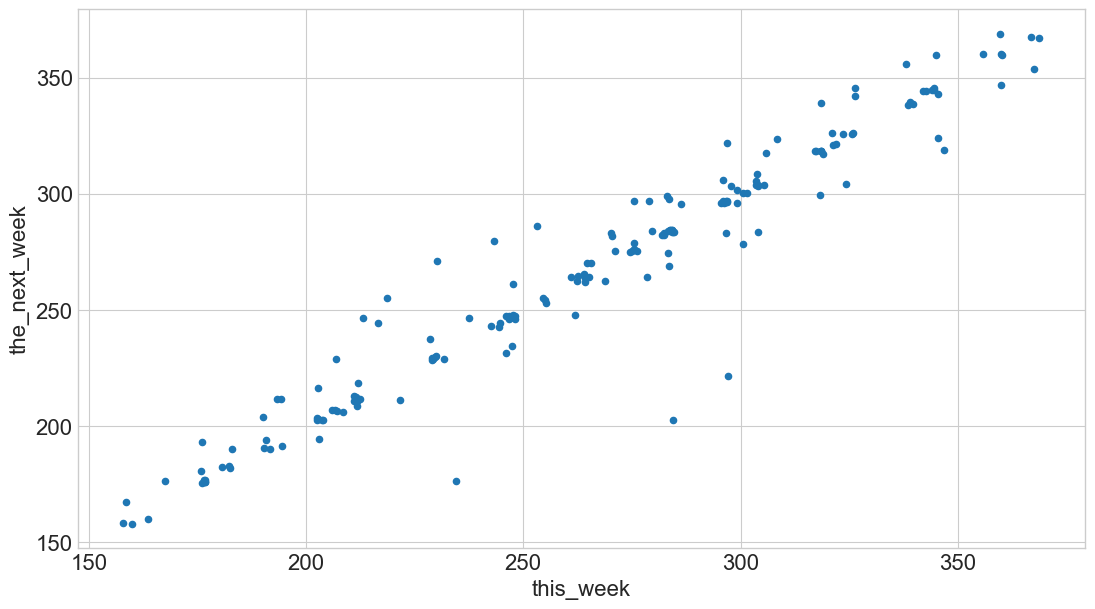

In [23]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.sales_total.shift(-1)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


<Axes: xlabel='y(t)', ylabel='y(t + 26)'>

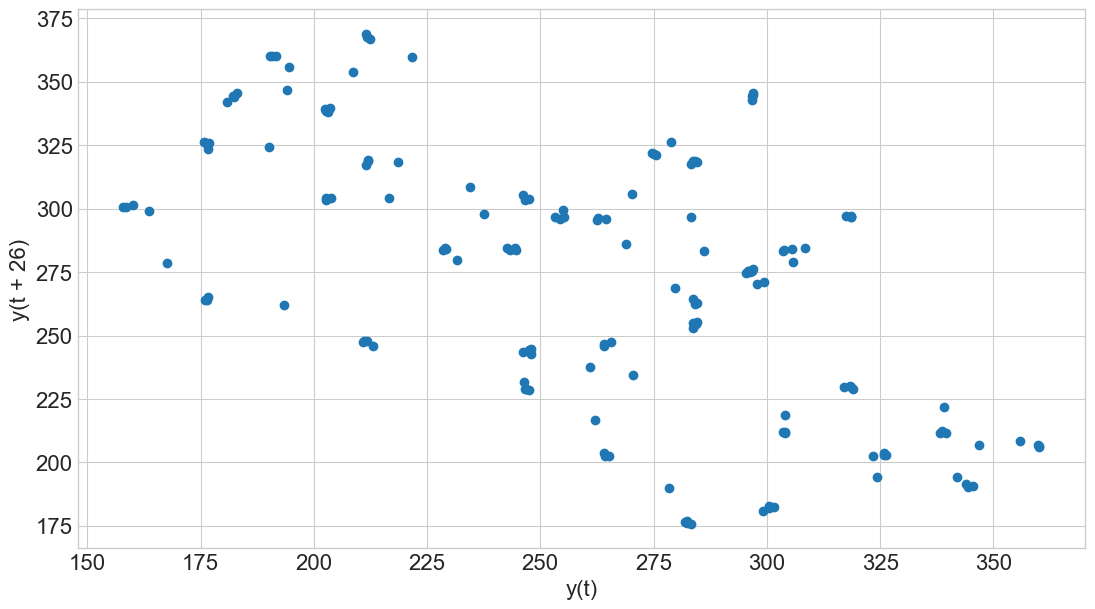

In [24]:
pd.plotting.lag_plot(train.sales_total.resample('W').mean(), lag=26)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

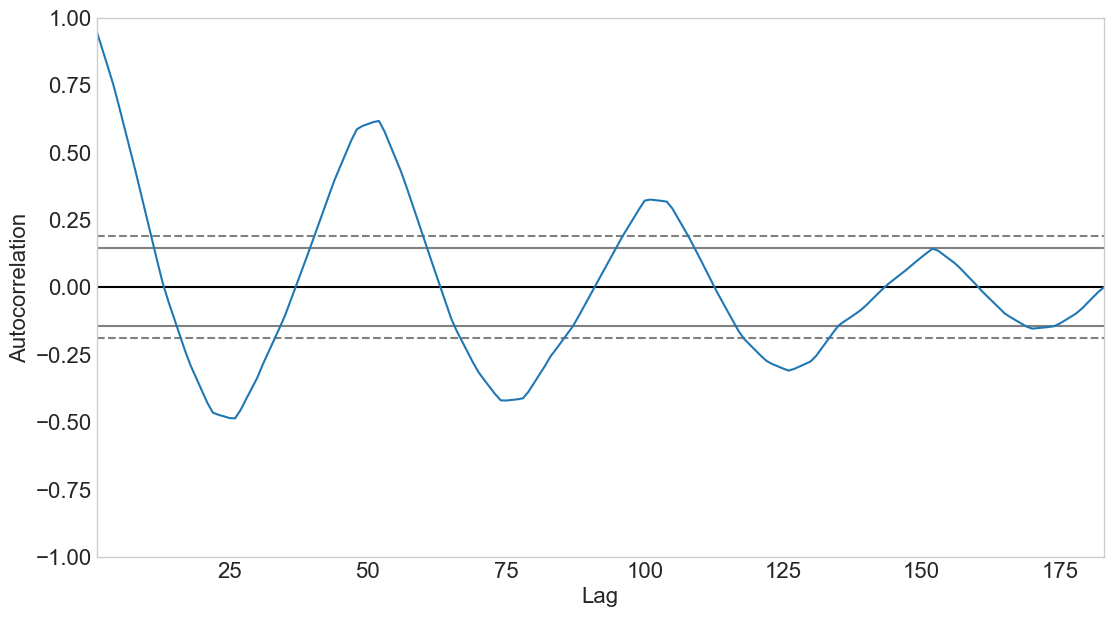

In [25]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())


In [26]:
y = train.sales_total.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


y  trend   seasonal  resid
sale_date                                      
2013-01-06  163.589167    NaN -77.817476    NaN
2013-01-13  159.981203    NaN -76.420497    NaN
2013-01-20  157.946720    NaN -77.661679    NaN
2013-01-27  158.545383    NaN -77.653888    NaN
2013-02-03  167.585014    NaN -73.077371    NaN

<Axes: xlabel='sale_date'>

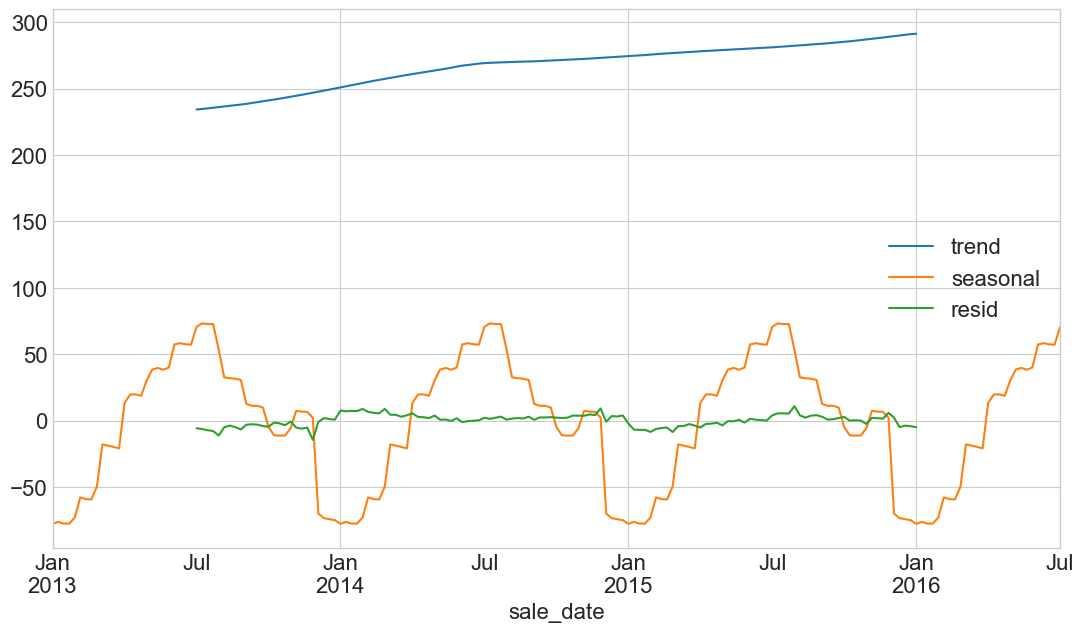

In [27]:
decomposition.iloc[:, 1:].plot()


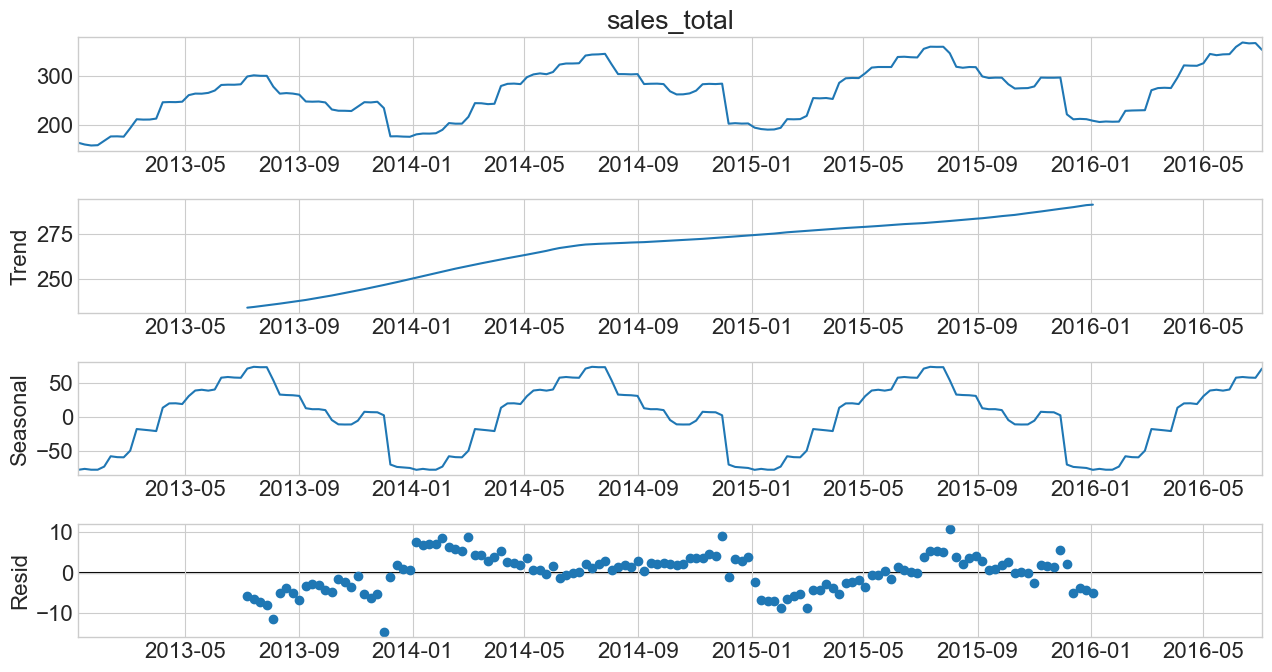

In [28]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [29]:
store_df.sales_total.min()

0.0

In [30]:
store_df.sales_total.max()

2104.41

In [31]:
store_df.sales_total.value_counts()

41.76      1534
16.80      1489
12.60      1346
52.20      1208
80.19      1145
           ... 
1435.90       1
1885.77       1
1415.10       1
713.74        1
1206.15       1
Name: sales_total, Length: 5332, dtype: int64

In [32]:
total_bin = [i for i in range(0, 2001, 400)]

# Define the bin labels (optional, you can use labels=['0-399', '400-799', ...] for custom labels)
bin_labels = [f'{edge}-{edge+399}' for edge in total_bin[:-1]]

# Bin the 'sales_total' column
train['sales_total_bin'] = pd.cut(train['sales_total'], bins=total_bin, labels=bin_labels)

# Print the result
print(train[['sales_total', 'sales_total_bin']].head())

store_df.head()

            sales_total sales_total_bin
sale_date                              
2013-01-01        10.92           0-399
2013-01-01        30.16           0-399
2013-01-01       308.48           0-399
2013-01-01       197.55           0-399
2013-01-01        25.16           0-399


item_upc14   item_upc12          item_brand  \
sale_date                                                  
2013-01-01  35200264013  35200264013            Riceland   
2013-01-01  88313590791  88313590791               Ducal   
2013-01-01  70177154004  70177154004  Twinings Of London   
2013-01-01  21200725340  21200725340              Scotch   
2013-01-01  41520035646  41520035646             Careone   

                                                    item_name  item_price  \
sale_date                                                                   
2013-01-01                     Riceland American Jazmine Rice        0.84   
2013-01-01                            Ducal Refried Red Beans        1.16   
2013-01-01  Twinings Of London Classics Lady Grey Tea - 20 Ct        9.64   
2013-01-01    Scotch Removable Clear Mounting Squares - 35 Ct        4.39   
2013-01-01                     Careone Family Comb Set - 8 Ct        0.74   

            sale_id  store_id  item_id.1  sale_amount  store_id.1  \
sale_date                                                           
2013-01-01        1         1          1           13           1   
2013-01-01   295813         3         17           26           3   
2013-01-01   125995        10          7           32          10   
2013-01-01   314073         3         18           45           3   
2013-01-01   332333         3         19           34           3   

                      store_address  store_zipcode   store_city store_state  \
sale_date                                                                     
2013-01-01   12125 Alamo Ranch Pkwy          78253  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   
2013-01-01     8503 NW Military Hwy          78231  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   
2013-01-01  2118 Fredericksburg Rdj          78201  San Antonio          TX   

            month  day_of_week  sales_total  
sale_date                                    
2013-01-01      1            1        10.92  
2013-01-01      1            1        30.16  
2013-01-01      1            1       308.48  
2013-01-01      1            1       197.55  
2013-01-01      1            1        25.16

Text(0, 0.5, '% of days in the month')

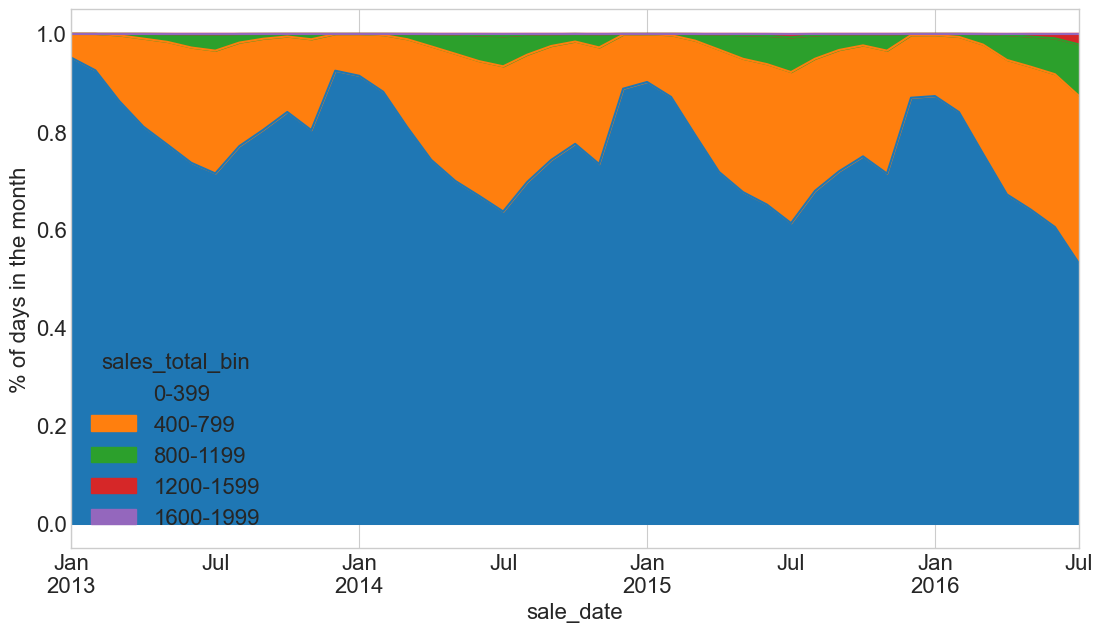

In [33]:
(train.groupby('sales_total_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')


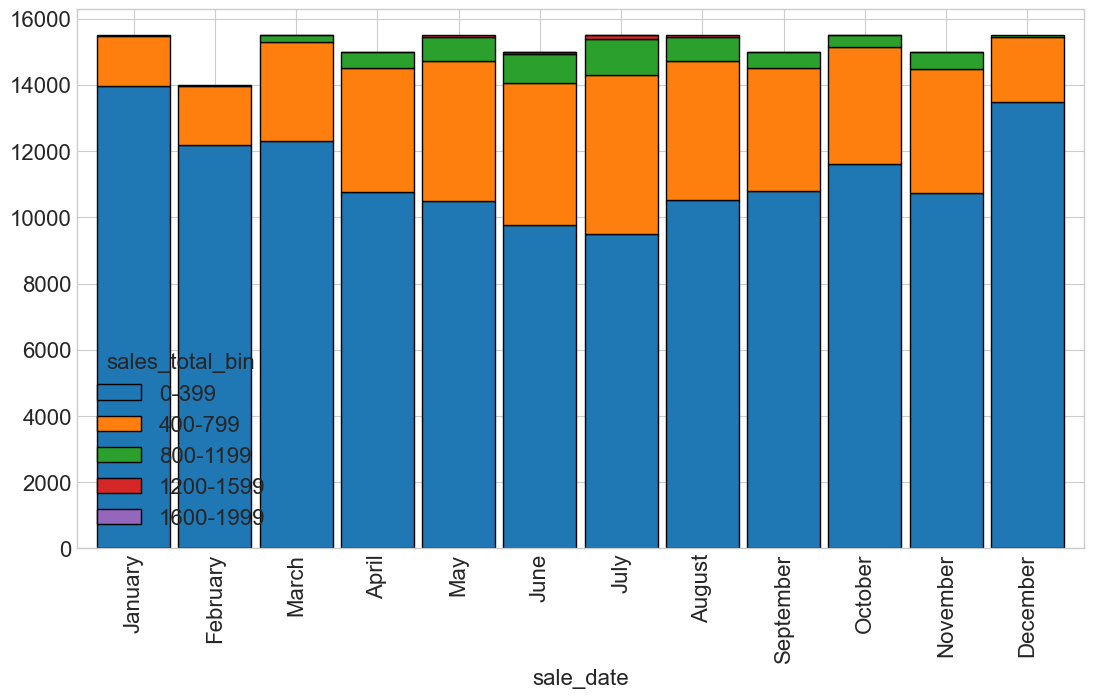

In [34]:
ax = (train.loc['2015']
 .groupby('sales_total_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);


## Strftime

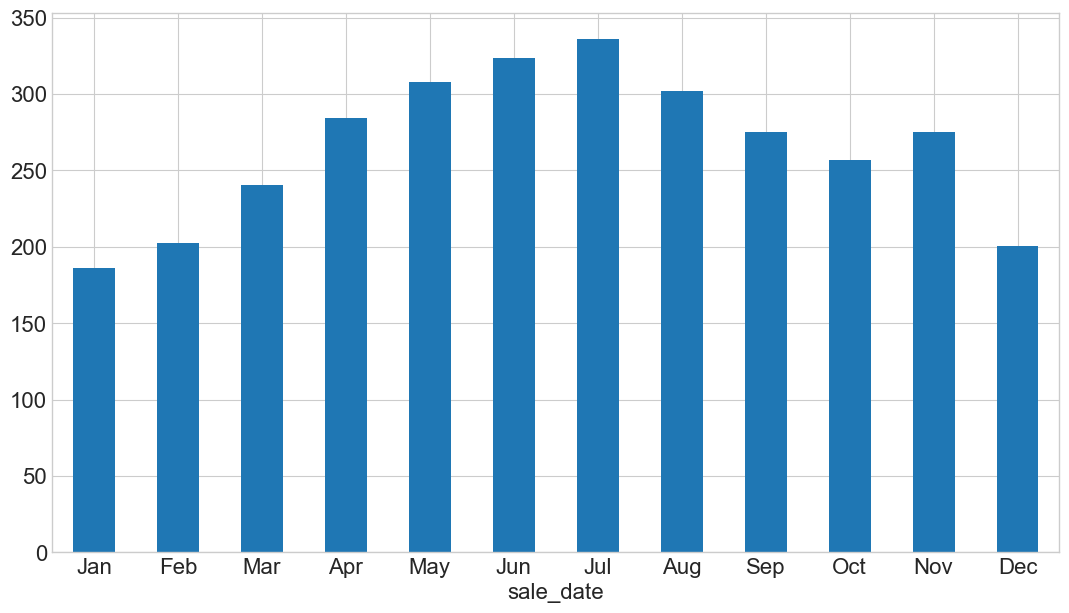

In [35]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


## Matplotlib Dates

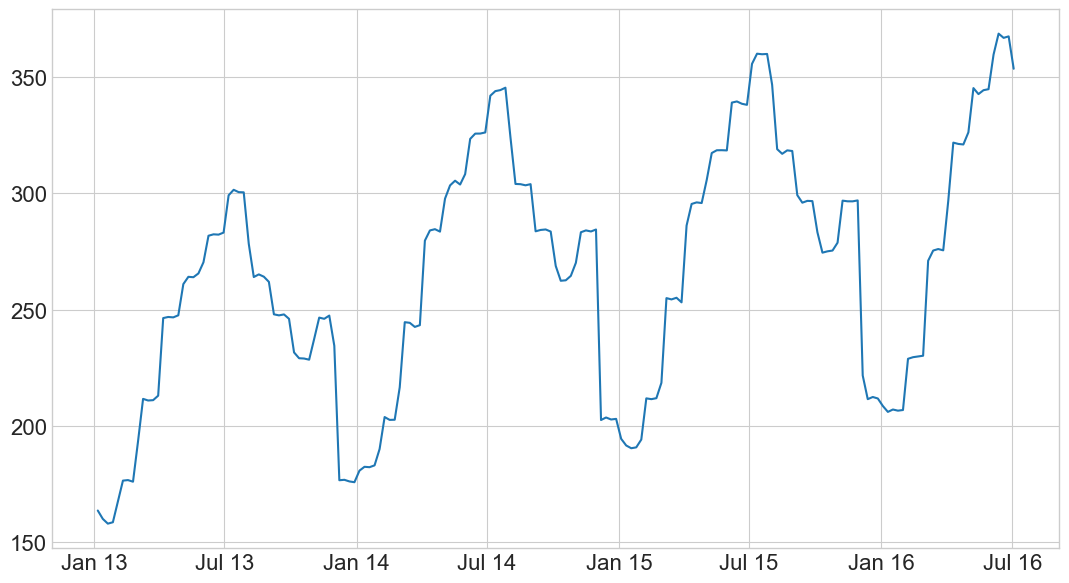

In [36]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


### opsd df

In [37]:
store_df = p.wrangle_opsd()

In [38]:
store_df.head()

Consumption    Wind  Solar  Wind+Solar  month  day_of_week
Date                                                                  
2006-01-01     1069.184  48.709  6.587     234.052      1            6
2006-01-02     1380.521  48.709  6.587     234.052      1            0
2006-01-03     1442.533  48.709  6.587     234.052      1            1
2006-01-04     1457.217  48.709  6.587     234.052      1            2
2006-01-05     1477.131  48.709  6.587     234.052      1            3

In [39]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)


In [40]:
print('Date Range:', store_df.index.min(), 'to', store_df.index.max())
print('Shape:', store_df.shape)

Date Range: 2006-01-01 00:00:00 to 2017-12-31 00:00:00
Shape: (4383, 6)


In [41]:
train_size = .70
n = store_df.shape[0]
test_start_index = round(train_size * n)

train = store_df[:test_start_index]
test = store_df[test_start_index:] 

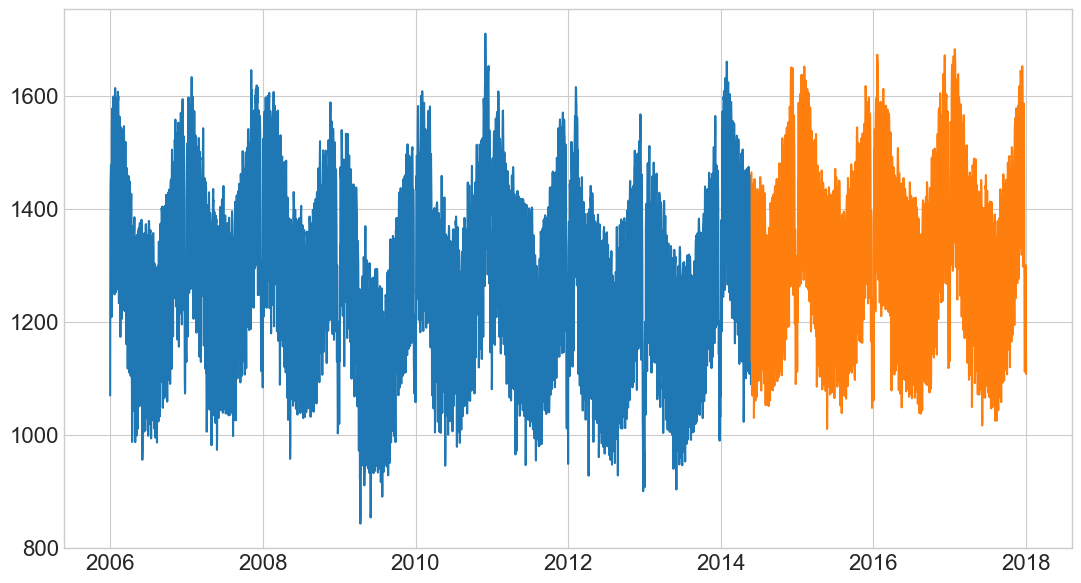

In [43]:
plt.plot(train.index, train.Consumption)
plt.plot(test.index, test.Consumption)

In [44]:
y = train.Consumption
y.head()


Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

<Axes: ylabel='Frequency'>

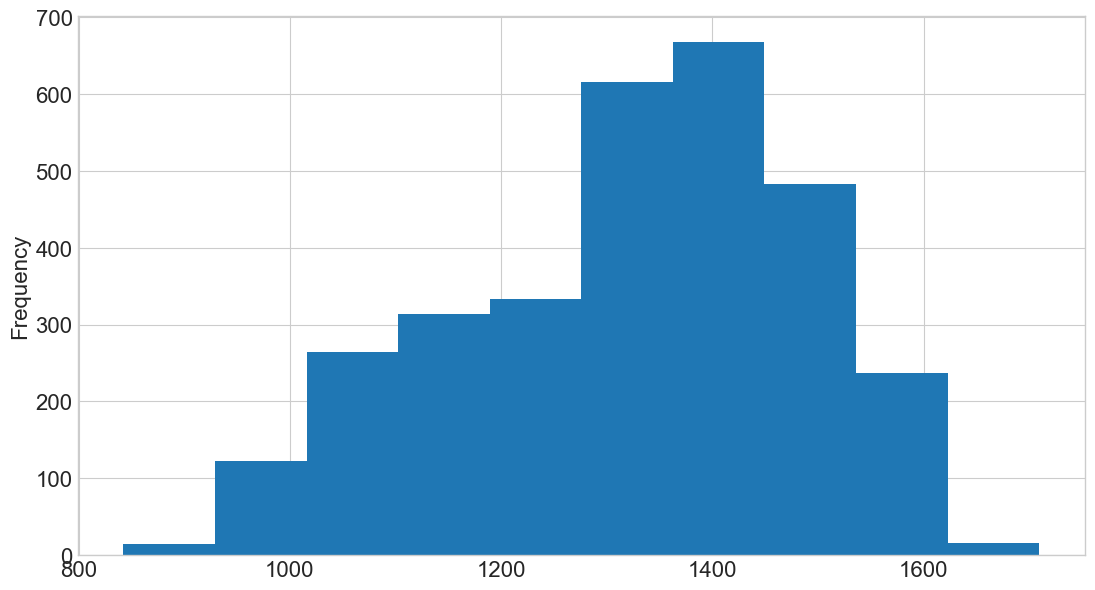

In [45]:
y.plot.hist()


[Text(0.5, 1.0, 'Average Consumption by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Consumption ($)')]

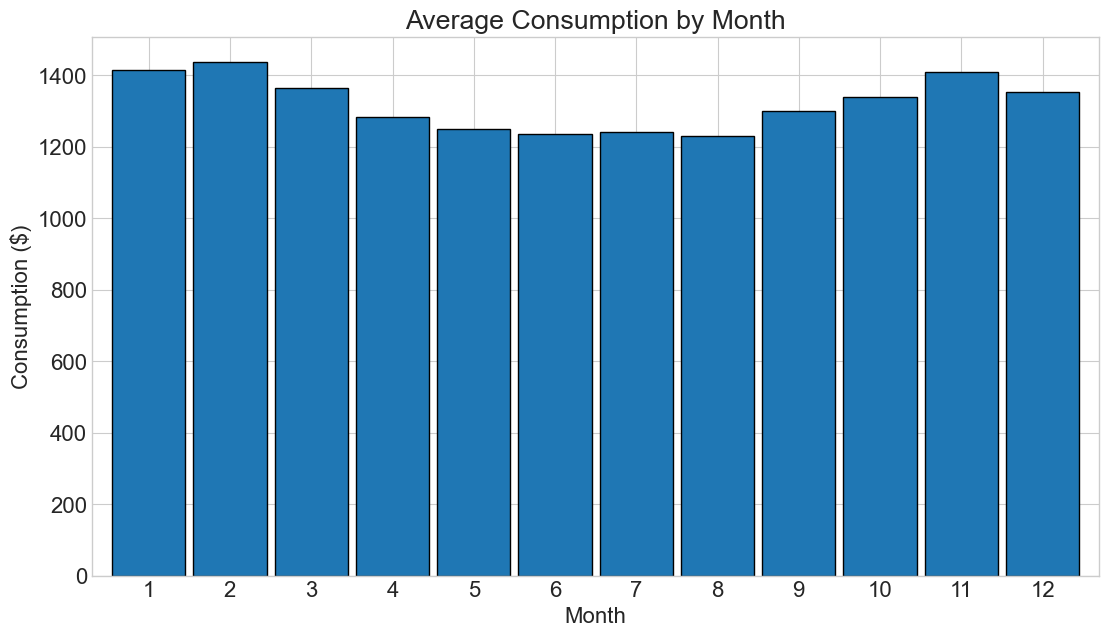

In [46]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Month', xlabel='Month', ylabel='Consumption ($)')


[Text(0.5, 1.0, 'Average Consumption by Weekday'),
 Text(0.5, 30.0, 'Weekday'),
 Text(32.0, 0.5, 'Consumption')]

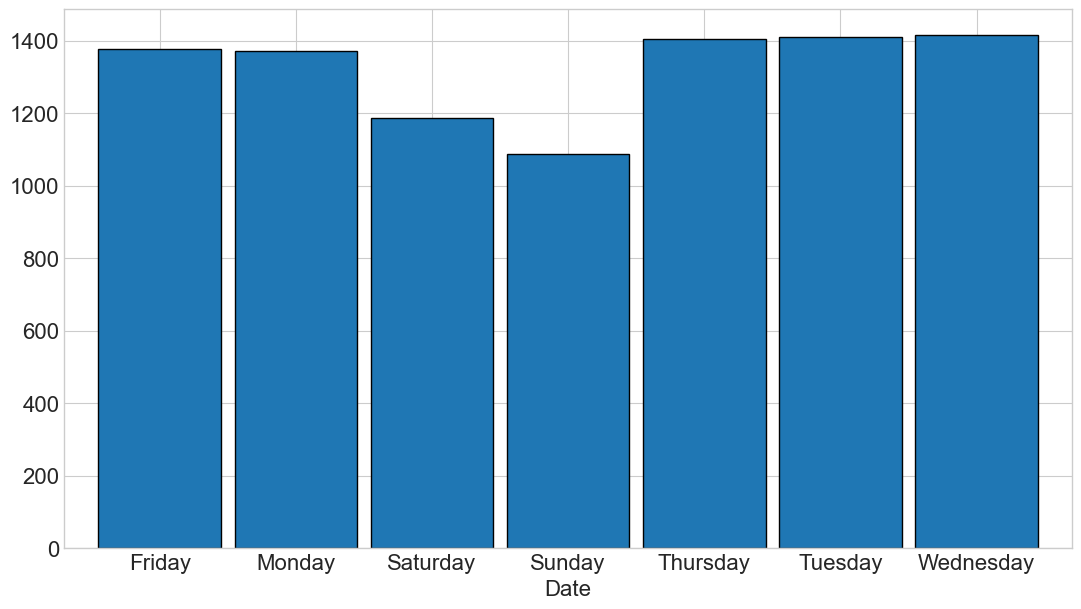

In [47]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Weekday', xlabel='Weekday', ylabel='Consumption')


<Axes: xlabel='weekday', ylabel='Consumption'>

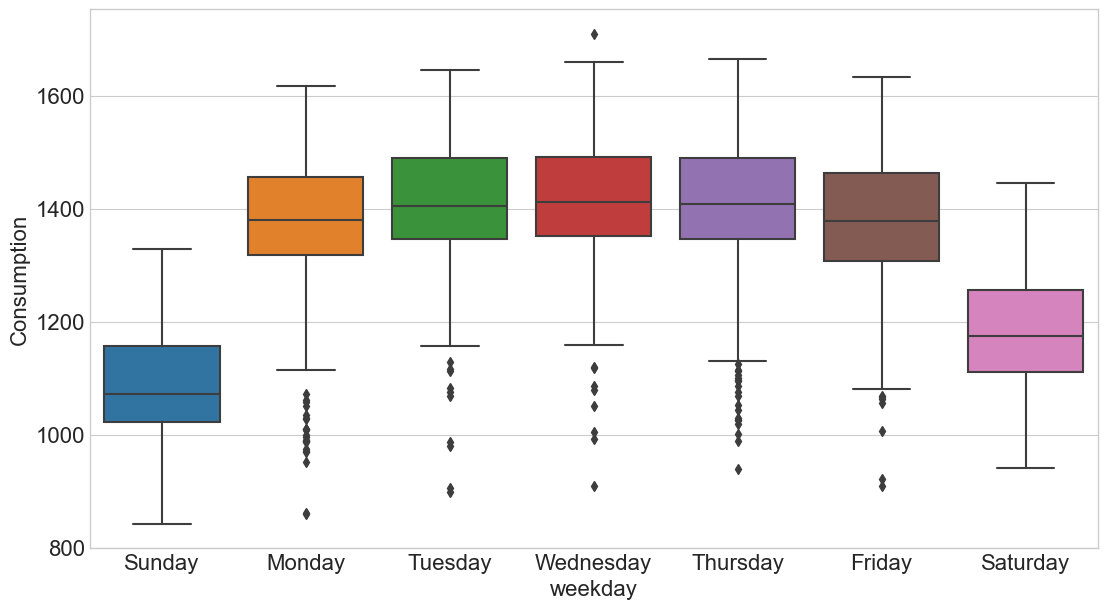

In [50]:
(
    y.reset_index()
    .assign(weekday=lambda store_df: store_df.Date.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='Consumption', x='weekday')
)


<Axes: xlabel='Date'>

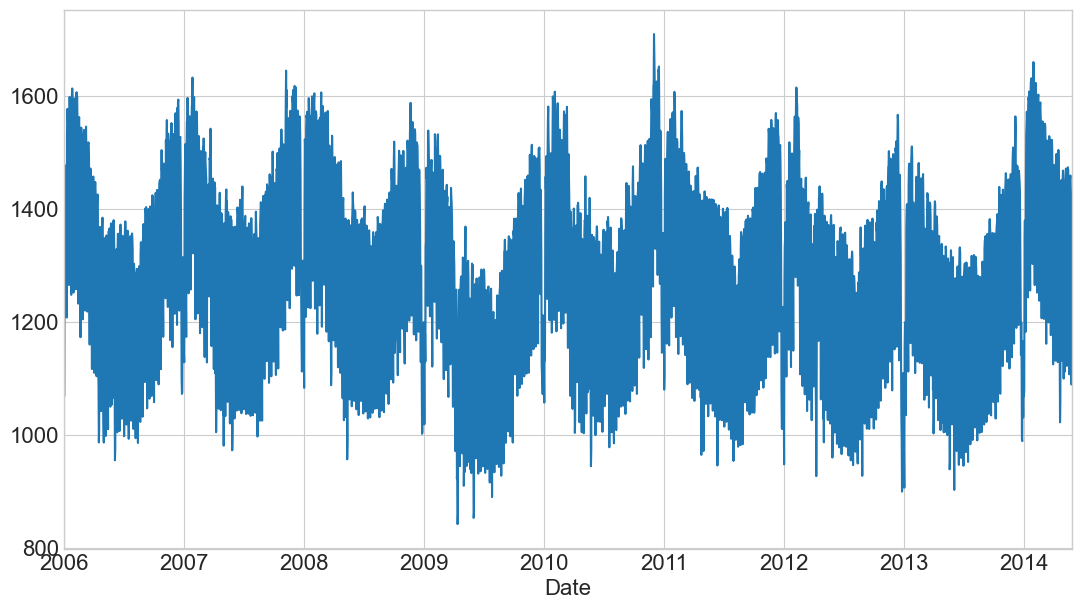

In [51]:
y.plot()


<Axes: title={'center': 'day average'}, xlabel='Date'>

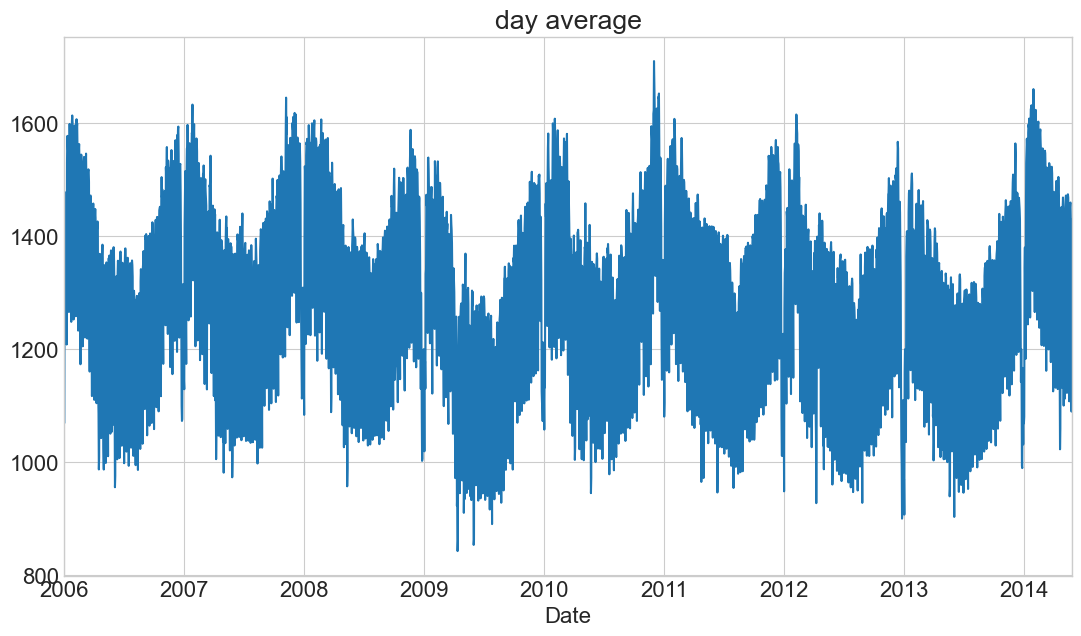

In [52]:
y.resample('D').mean().plot(title='day average')


## 2 week avg sales total

<Axes: title={'center': '2 week average Consumption'}, xlabel='Date'>

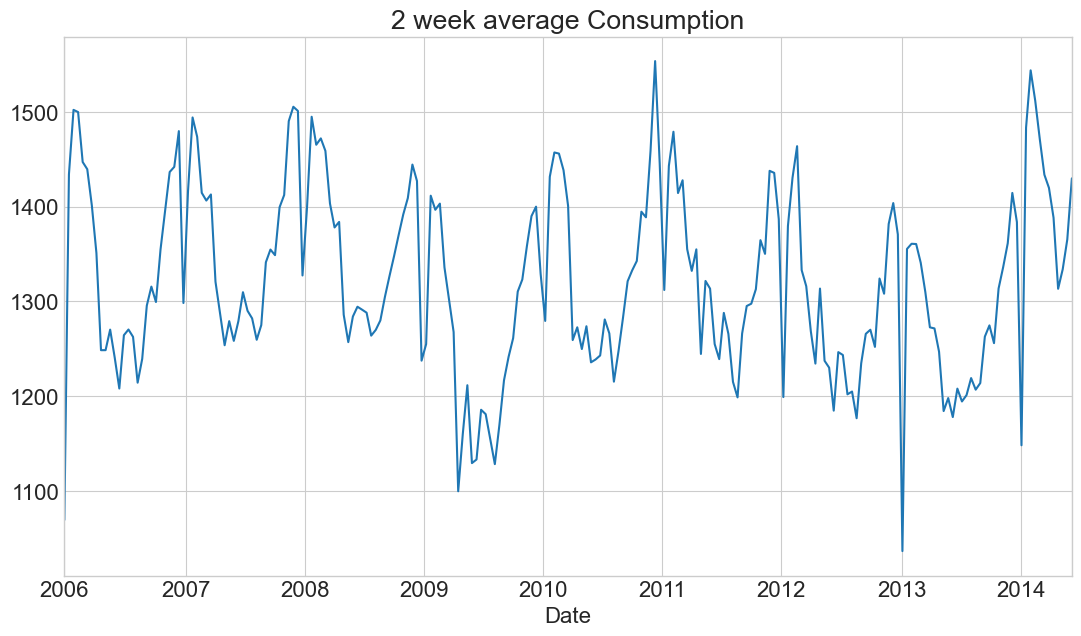

In [53]:
y.resample('2W').mean().plot(title='2 week average Consumption')


## Visualizations to see how the aggregating smoothes out the data.

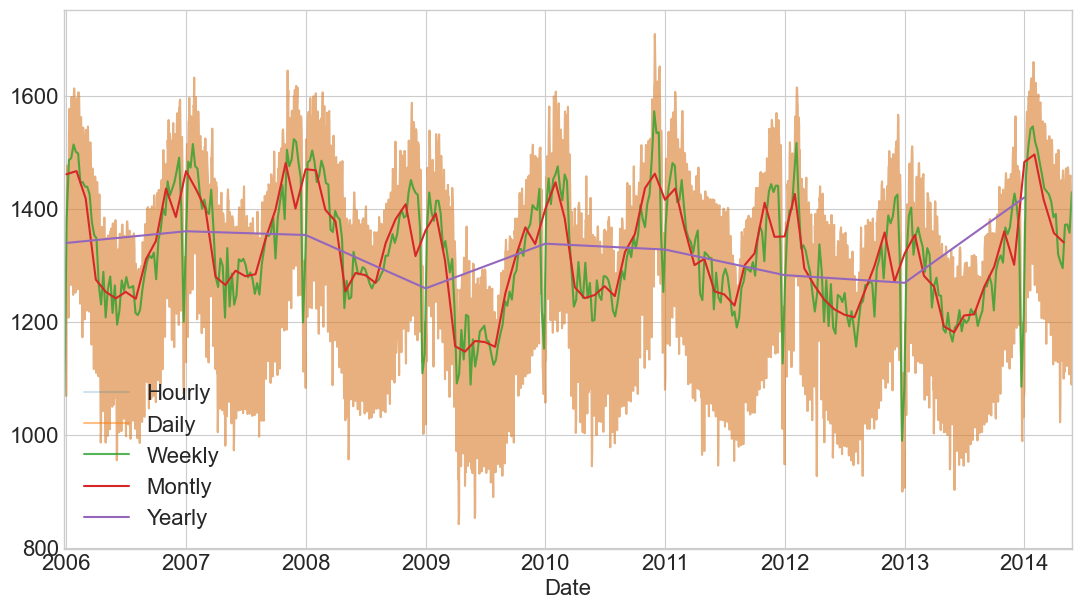

In [54]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


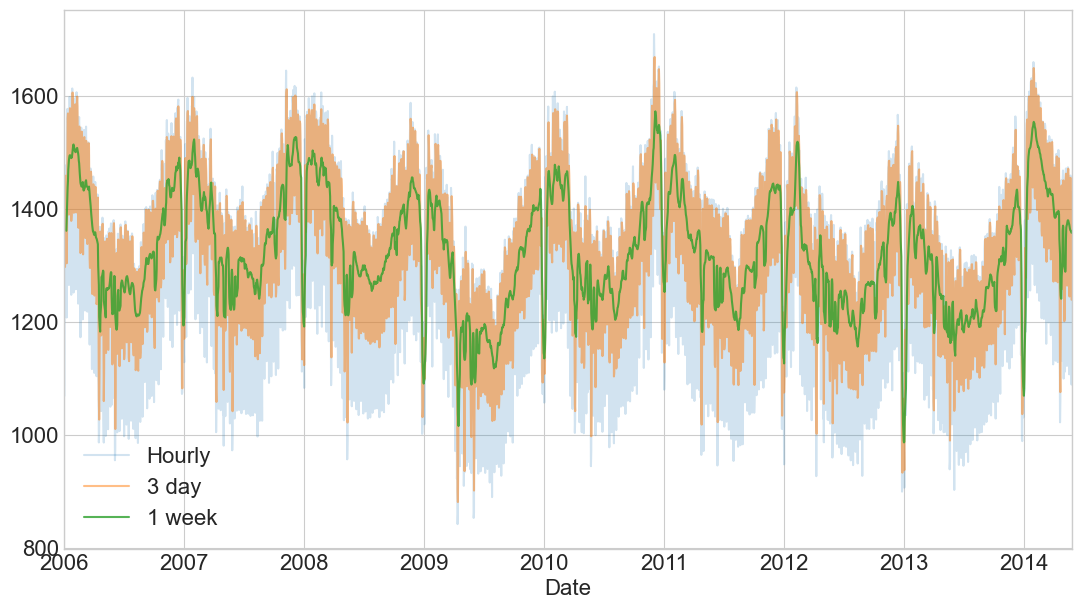

In [55]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

## Avg Week to Week sales total

<Axes: title={'center': 'Average week-to-week change in Consumption'}, xlabel='Date'>

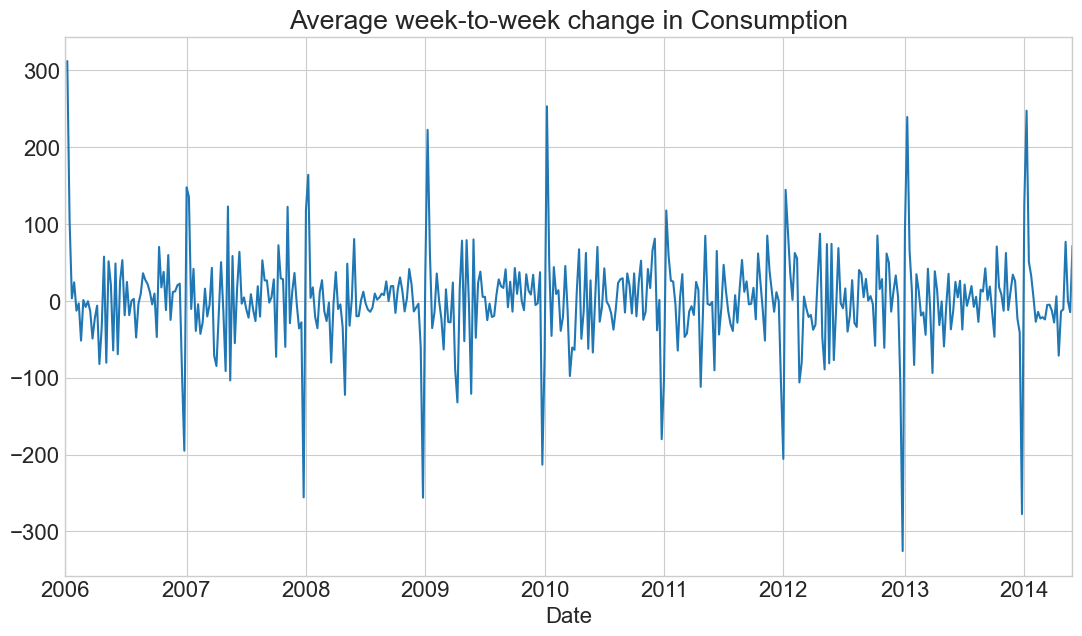

In [56]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in Consumption')


## Average M to M plot

<Axes: title={'center': 'Average month-to-month change in Consumption'}, xlabel='Date'>

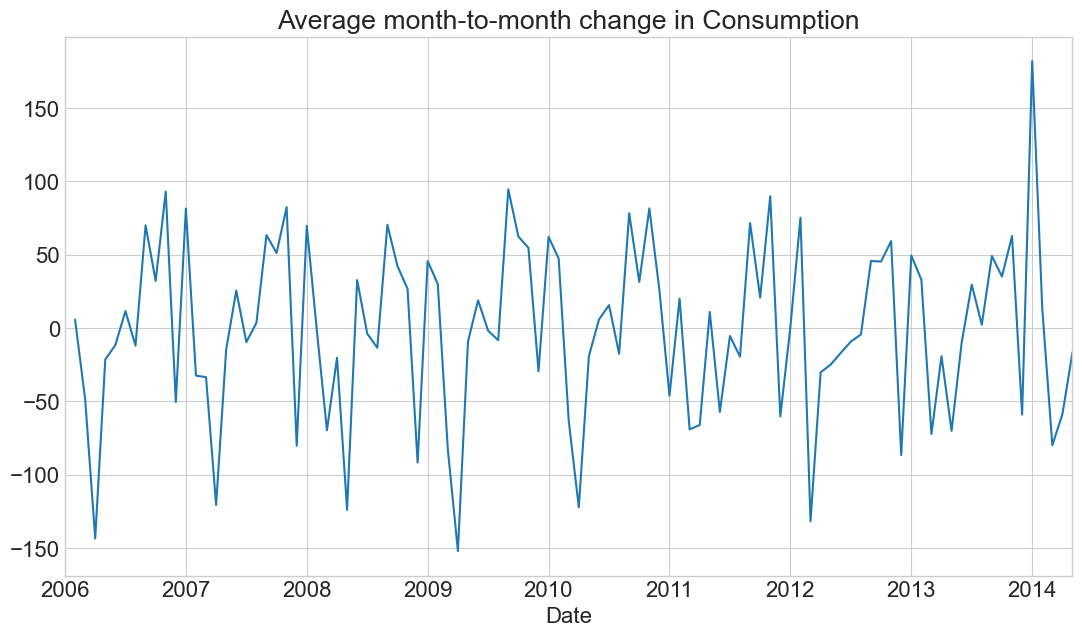

In [57]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in Consumption')


## Seasonal plot

<Axes: title={'center': 'Seasonal Plot'}, xlabel='Date'>

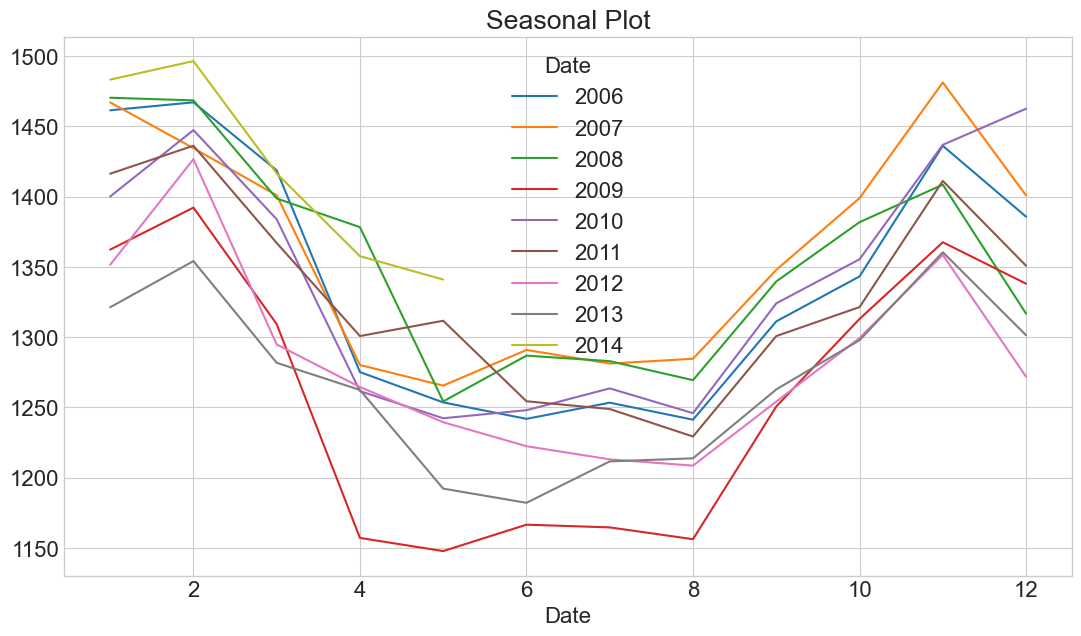

In [58]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


## Seasonal subseries Plot

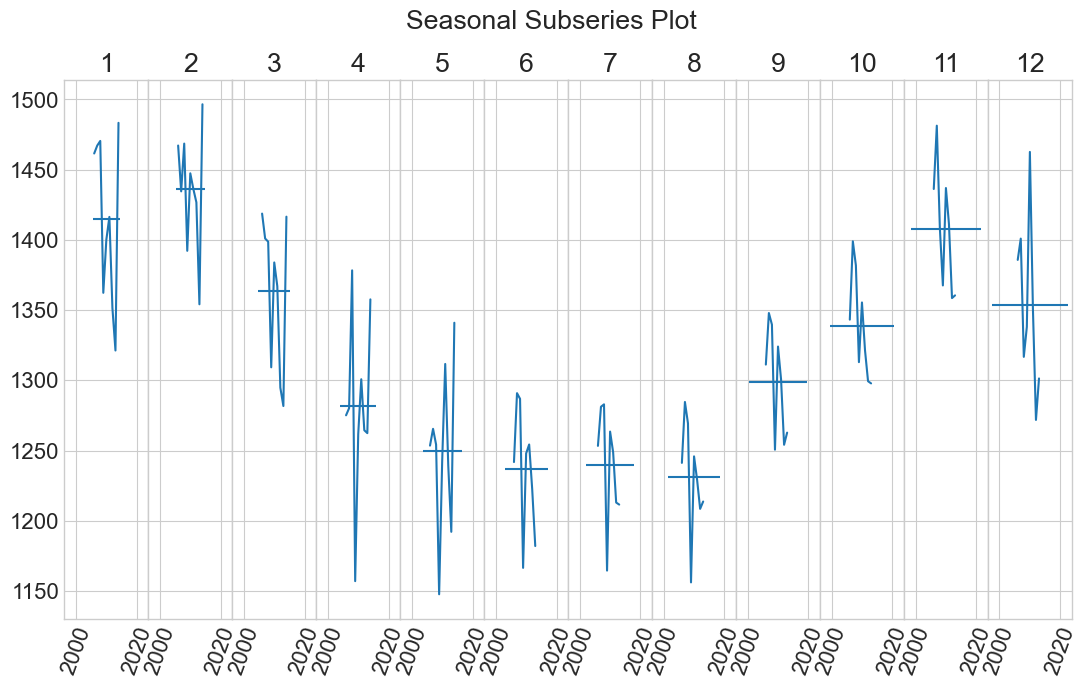

In [59]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iterrows()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    ax.set_xticklabels([int(thing) for thing in ax.get_xticks()], rotation = 70)

fig.suptitle('Seasonal Subseries Plot')
fig.subplots_adjust(wspace=0)


## Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

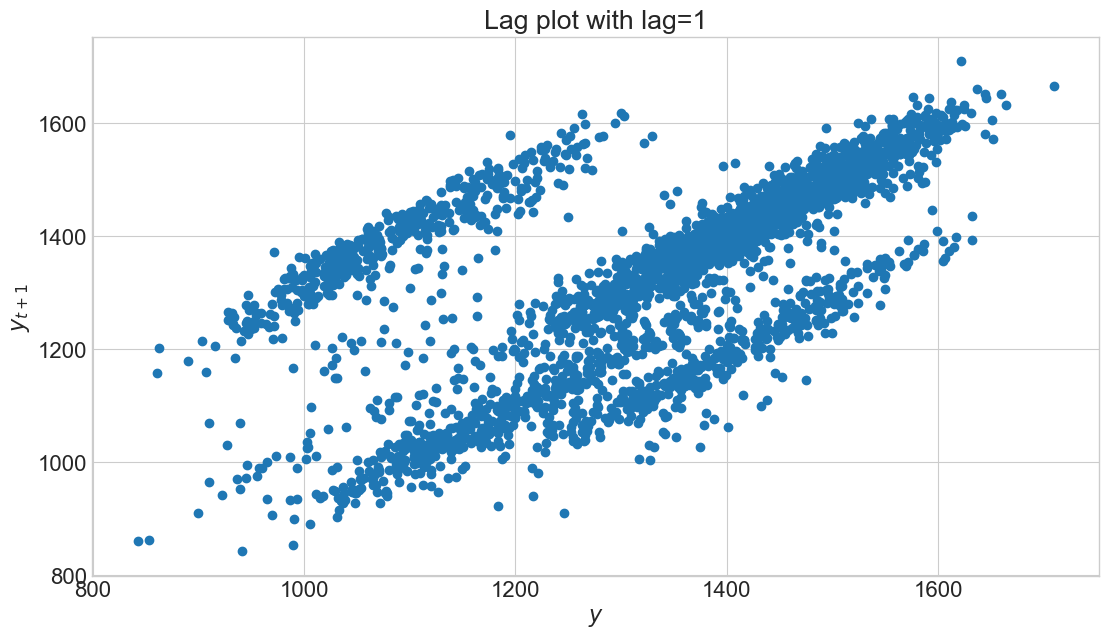

In [60]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


this_week        Wind       Solar  Wind+Solar     month  \
Date                                                                    
2006-01-01  1069.184000   48.709000    6.587000  234.052000  1.000000   
2006-01-08  1381.300143   48.709000    6.587000  234.052000  1.000000   
2006-01-15  1486.730286   48.709000    6.587000  234.052000  1.000000   
2006-01-22  1490.031143   48.709000    6.587000  234.052000  1.000000   
2006-01-29  1514.176857   48.709000    6.587000  234.052000  1.000000   
...                 ...         ...         ...         ...       ...   
2014-05-04  1295.405714   52.989714  110.741857  163.731571  4.571429   
2014-05-11  1372.166000  204.100143  124.597143  328.697286  5.000000   
2014-05-18  1372.636143  117.518286  131.462000  248.980286  5.000000   
2014-05-25  1357.924714   57.100000  169.838857  226.938857  5.000000   
2014-06-01  1429.811000  138.365000  137.176000  275.541000  5.000000   

            day_of_week  the_next_week  
Date                                    
2006-01-01          6.0    1381.300143  
2006-01-08          3.0    1486.730286  
2006-01-15          3.0    1490.031143  
2006-01-22          3.0    1514.176857  
2006-01-29          3.0    1501.403286  
...                 ...            ...  
2014-05-04          3.0    1372.166000  
2014-05-11          3.0    1372.636143  
2014-05-18          3.0    1357.924714  
2014-05-25          3.0    1429.811000  
2014-06-01          0.0            NaN  

[440 rows x 7 columns]

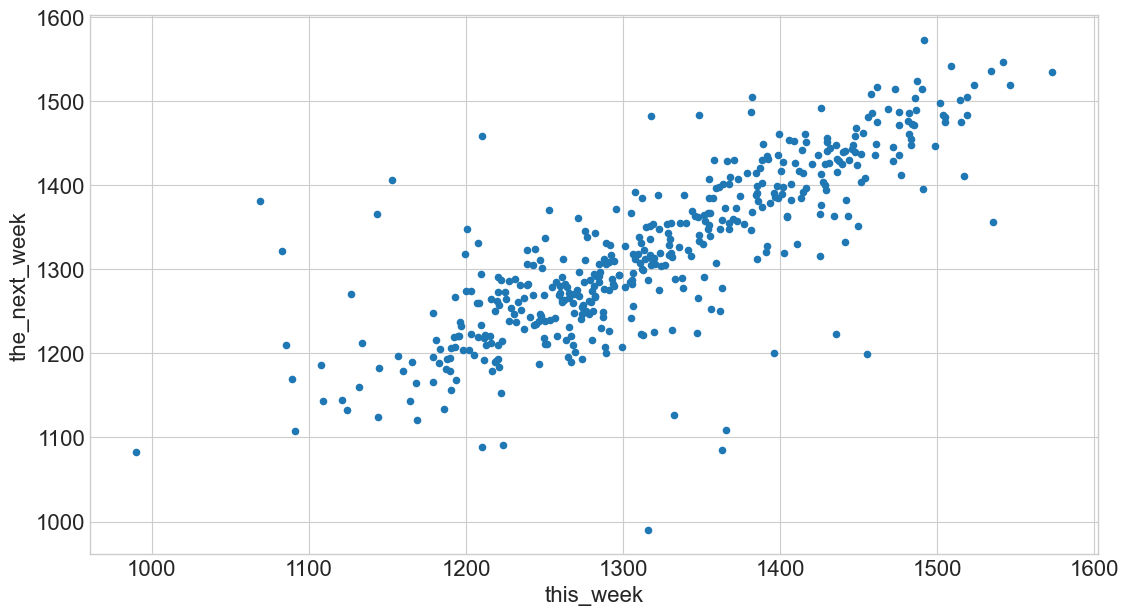

In [61]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.Consumption.shift(-1)
weekly = weekly.rename(columns={'Consumption': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


<Axes: xlabel='y(t)', ylabel='y(t + 26)'>

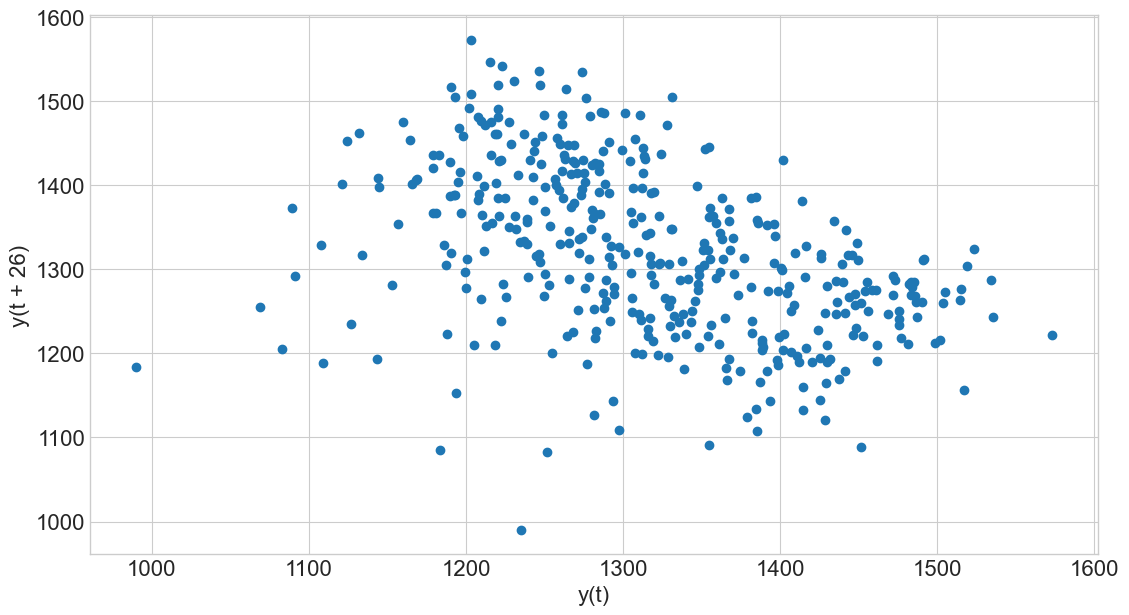

In [62]:
pd.plotting.lag_plot(train.Consumption.resample('W').mean(), lag=26)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

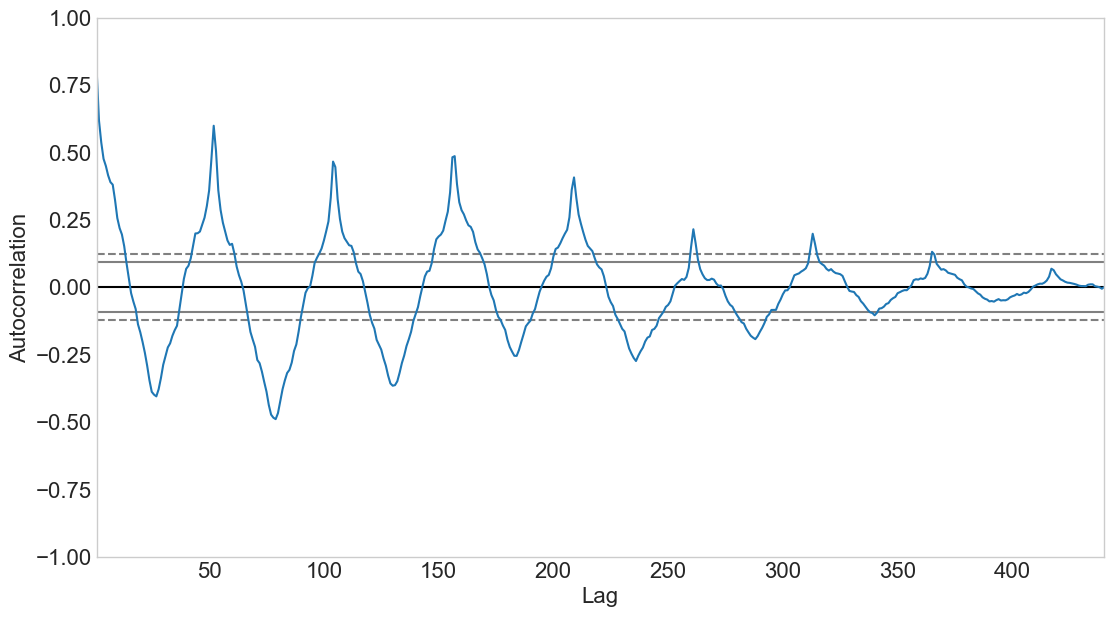

In [63]:
pd.plotting.autocorrelation_plot(train.Consumption.resample('W').mean())


In [64]:
y = train.Consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


y  trend    seasonal  resid
Date                                             
2006-01-01  1069.184000    NaN  -68.437315    NaN
2006-01-08  1381.300143    NaN -125.834756    NaN
2006-01-15  1486.730286    NaN   35.842411    NaN
2006-01-22  1490.031143    NaN  106.451350    NaN
2006-01-29  1514.176857    NaN  122.022124    NaN

<Axes: xlabel='Date'>

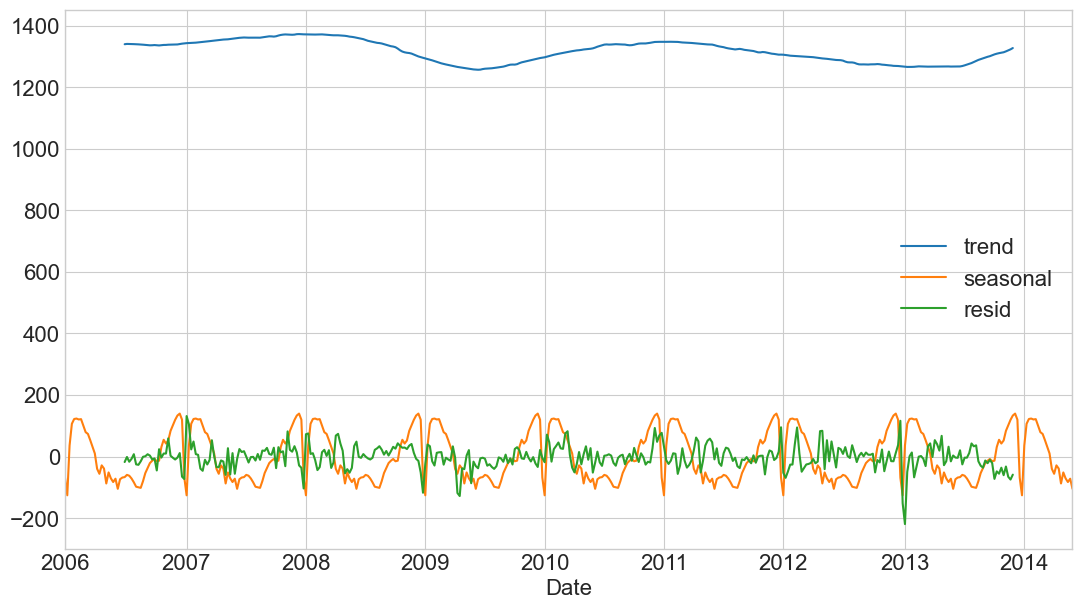

In [65]:
decomposition.iloc[:, 1:].plot()


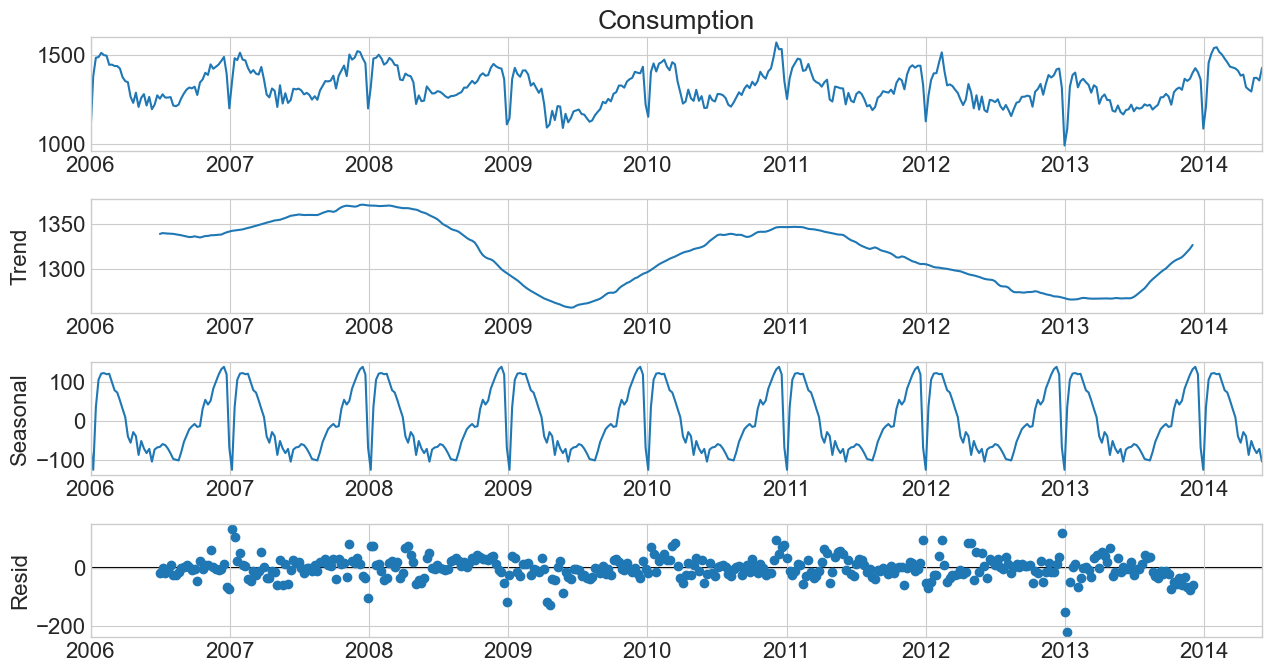

In [67]:

result.plot()
None


In [68]:
store_df.Consumption.min()

842.395

In [69]:
store_df.Consumption.max()

1709.5679999999998

In [70]:
store_df.Consumption.value_counts()

1103.82300    2
1597.27500    2
1383.50400    2
1348.18800    2
1350.43900    2
             ..
1493.43200    1
1489.44000    1
1380.07100    1
1240.76200    1
1107.11488    1
Name: Consumption, Length: 4374, dtype: int64

In [72]:
total_bin = [i for i in range(0, 2001, 400)]

# Define the bin labels (optional, you can use labels=['0-399', '400-799', ...] for custom labels)
bin_labels = [f'{edge}-{edge+399}' for edge in total_bin[:-1]]

# Bin the 'sales_total' column
train['Consumption_bin'] = pd.cut(train['Consumption'], bins=total_bin, labels=bin_labels)

# Print the result
print(train[['Consumption', 'Consumption_bin']].head())

train.head()

            Consumption Consumption_bin
Date                                   
2006-01-01     1069.184        800-1199
2006-01-02     1380.521       1200-1599
2006-01-03     1442.533       1200-1599
2006-01-04     1457.217       1200-1599
2006-01-05     1477.131       1200-1599


Consumption    Wind  Solar  Wind+Solar  month  day_of_week  \
Date                                                                     
2006-01-01     1069.184  48.709  6.587     234.052      1            6   
2006-01-02     1380.521  48.709  6.587     234.052      1            0   
2006-01-03     1442.533  48.709  6.587     234.052      1            1   
2006-01-04     1457.217  48.709  6.587     234.052      1            2   
2006-01-05     1477.131  48.709  6.587     234.052      1            3   

           Consumption_bin  
Date                        
2006-01-01        800-1199  
2006-01-02       1200-1599  
2006-01-03       1200-1599  
2006-01-04       1200-1599  
2006-01-05       1200-1599

Text(0, 0.5, '% of days in the month')

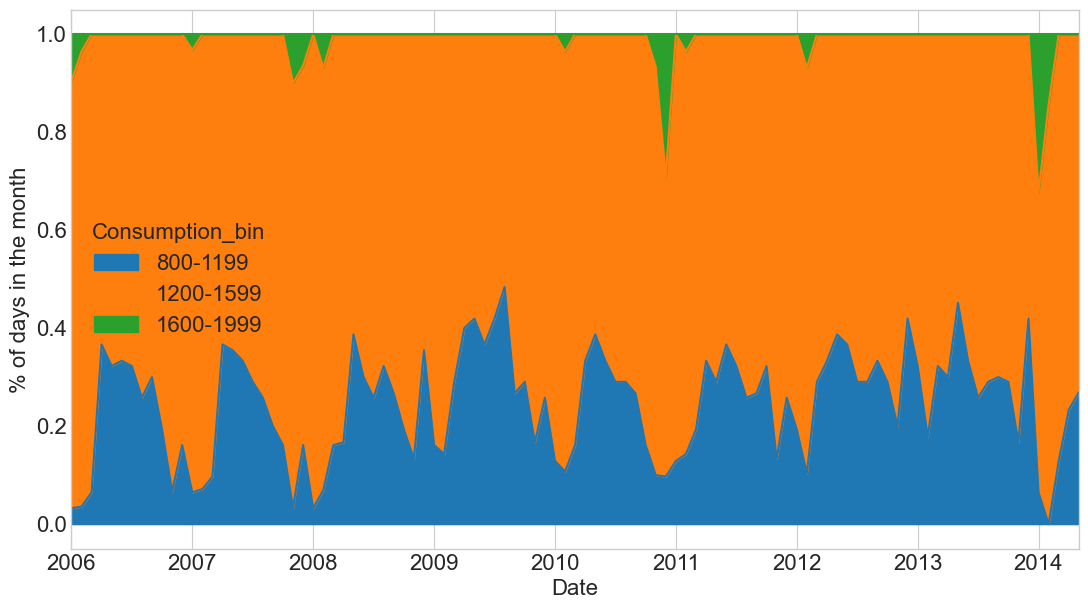

In [73]:
(train.groupby('Consumption_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')


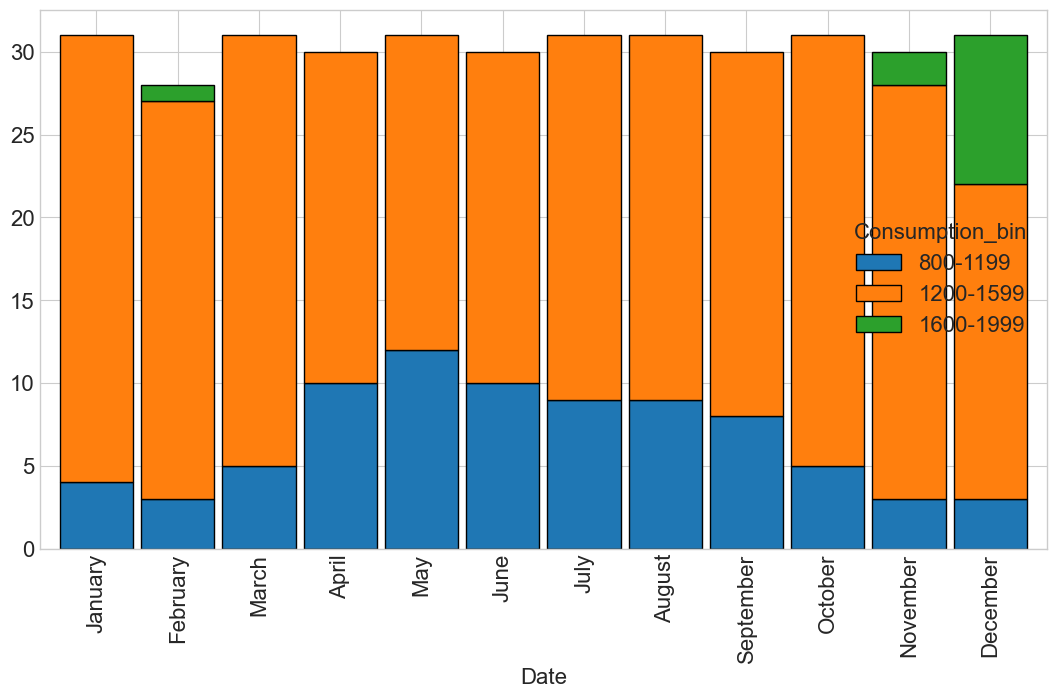

In [75]:
ax = (train.loc['2010']
 .groupby('Consumption_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);


## Strftime

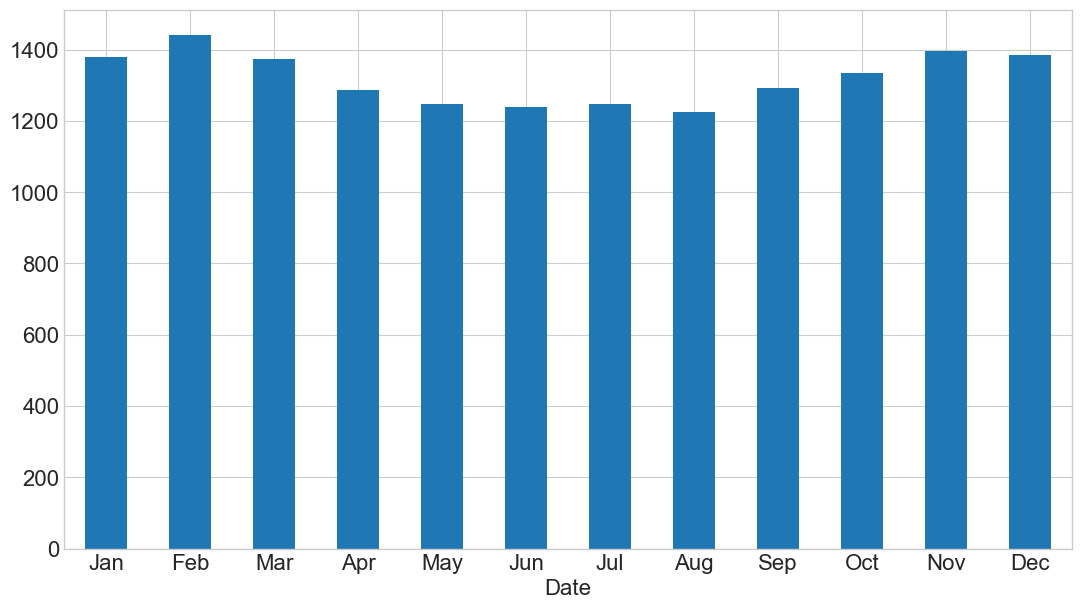

In [76]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


## Matplotlib Dates

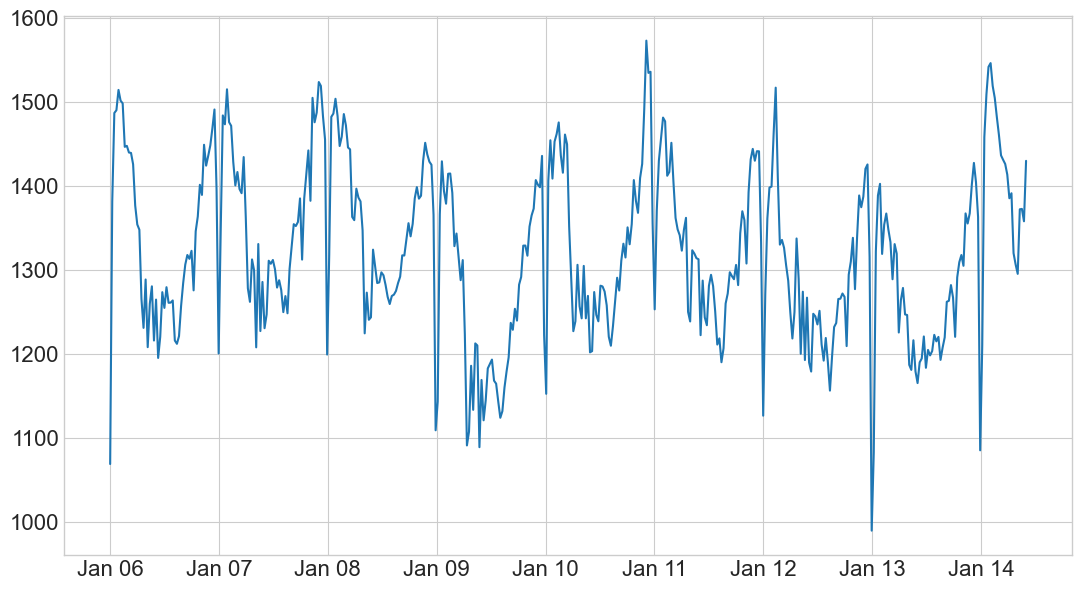

In [77]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
